In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)# import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from src.SFBC.convLayer import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

# from cutlass import *
# from rbfConv import *
from tqdm.autonotebook import tqdm
import random 
import numpy as np
from src.test_case_II.datautils import splitFile
from src.test_case_II.datautils import datasetLoader, loadFrame
from src.SFBC.detail.windows import getWindowFunction
from src.test_case_II.util import constructFluidFeatures
from src.SFBC.convNet import RbfNet
from datetime import datetime
import portalocker
from src.SFBC.detail.augment import augment
from src.test_case_II.training import processBatch
# from datautils import *
# from sphUtils import *
# from lossFunctions import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from src.test_case_II.util import setSeeds, loadDataset, getDataLoader, getFeatureSizes
from src.SFBC.detail.util import count_parameters
import json
from src.test_case_II.util import NumpyArrayEncoder
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from src.test_case_IV.training import loadFrame, runNetwork
from src.SFBC.detail.scatter import scatter_sum
from src.test_case_IV.eval import getUnrollFrame

cm = mpl.colormaps['viridis']
import matplotlib.colors as colors
import h5py

/tmp/ipykernel_606447/2037001457.py:74: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:

from src.test_case_IV.radius import periodicNeighborSearchXYZ
from src.SFBC.detail.scatter import scatter_sum
from src.test_case_IV.util import generateGrid, optimizeVolume
from src.test_case_IV.simplex import getSimplexNoisePeriodic3, _init
from src.test_case_IV.util import wendland, wendlandGrad
from src.test_case_IV.arguments import parser

args = parser.parse_args()

perm, _perm_grad_index3 = _init(1234)

setSeeds(args.seed, args.verbose)

if args.verbose:
    print('Available cuda devices:', torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if args.verbose:
    print('Running on Device %s' % device)
torch.set_num_threads(1)

In [5]:
inFile = h5py.File('../../datasets/test_case_IV/lowJitter.hdf5', 'r')
# inFile.close()

In [6]:
dataParameters = {}
for k in inFile.attrs.keys():
    dataParameters[k] = inFile.attrs[k]
dataEntries = len(inFile['simulationData'].keys())
trainingEntries = np.arange(0, dataEntries * 0.9)
testingEntries = np.arange(dataEntries * 0.9, dataEntries)

In [7]:
train_dataloader = DataLoader(list(inFile['simulationData'].keys()), shuffle=True, batch_size = args.batch_size)
train_iter = iter(train_dataloader)

In [8]:
bdata = next(train_iter)
print(bdata)

['803036', '146697', '471682', '6505']


In [9]:
def loadBatch(bdata, inFile):
    with record_function("Load Batch"): 
        processed = []
        for b in bdata:
            dataGrp = inFile['simulationData'][b]
            loaded = {}
            for g in dataGrp:
                loaded[g] = torch.tensor(np.array(dataGrp[g]))
    #             print(loaded[g])abs
            for a in dataGrp.attrs:
                loaded[a] = dataGrp.attrs[a]
            processed.append(loaded)
        return processed

In [10]:
batchData = loadBatch(bdata, inFile)
print(batchData[0].keys())

dict_keys(['gradRhoDifference', 'gradRhoNaive', 'gradRhoSymmetric', 'jitter', 'ni', 'rho', 'vols', 'x', 'frequency', 'seed'])


In [11]:
print(inFile.attrs['support']**3 * 4/3*np.pi / inFile.attrs['volume'])
print(inFile.attrs['volume'])

51.08784586048442
0.0019115358722833816


In [18]:
from src.test_case_IV.plotting import plotSlices
from src.test_case_IV.util import genData

def constructInputs(bdata, inFile, device, features = ['one', 'volume'], target = 'gradRhoDifference', dataOverride = None):
    with record_function("Construct Inputs"): 
        batchData = loadBatch(bdata, inFile) if dataOverride is None else dataOverride
        positions = torch.vstack([b['x'] for b in batchData])
        batchIndex = torch.hstack([torch.ones_like(b['rho']) * i for i, b in enumerate(batchData)])

        collectedFeatures = []
        for f in features:
            if f == 'one':
                collectedFeatures.append(torch.hstack([torch.ones_like(b['rho']) for b in batchData])[:,None])
            elif f == 'zero':
                collectedFeatures.append(torch.hstack([torch.zeros_like(b['rho']) for b in batchData])[:,None])
            elif f == 'volume':
                collectedFeatures.append(torch.hstack([b['vols'] for b in batchData])[:,None])
            elif f == 'normalizedVolume':
                collectedFeatures.append(torch.hstack([b['vols'] for b in batchData])[:,None] / (4/3 * np.pi * inFile.attrs['support']**3) * inFile.attrs['numNeighbors'])
            elif f == 'ni':
                collectedFeatures.append(torch.hstack([b['ni'] for b in batchData])[:,None])
            elif f == 'rho':
                collectedFeatures.append(torch.hstack([b['rho'] for b in batchData])[:,None])
            elif f == 'rhoTimesVolume':
                collectedFeatures.append(torch.hstack([b['rho'] * b['vols'] for b in batchData])[:,None])
            elif f == 'rhoTimesNormalizedVolume':
                collectedFeatures.append(torch.hstack([b['rho'] * b['vols'] for b in batchData])[:,None] / (4/3 * np.pi * inFile.attrs['support']**3) * inFile.attrs['numNeighbors'])
            elif f == 'rhoOverVolume':
                collectedFeatures.append(torch.hstack([b['rho'] * b['vols'] for b in batchData])[:,None])
            elif f == 'rhoOverNormalizedVolume':
                collectedFeatures.append(torch.hstack([b['rho'] / b['vols'] for b in batchData])[:,None]* (4/3 * np.pi * inFile.attrs['support']**3) * inFile.attrs['numNeighbors'])
            elif f == 'volumeOverRho':
                collectedFeatures.append(torch.hstack([b['vols'] * b['rho'] for b in batchData])[:,None])
            elif f == 'normalizedVolumeOverRho':
                collectedFeatures.append(torch.hstack([b['vols'] / b['rho'] for b in batchData])[:,None]/ (4/3 * np.pi * inFile.attrs['support']**3) * inFile.attrs['numNeighbors'])
            elif f == 'frequency':
                collectedFeatures.append(torch.hstack([torch.ones_like(b['rho']) * b['frequency'] for b in batchData])[:,None])
            elif f == 'seed':
                collectedFeatures.append(torch.hstack([torch.ones_like(b['rho']) * b['seed'] for b in batchData])[:,None])
            else:
                collectedFeatures.append(torch.vstack([b[f] for b in batchData]))        

        features = torch.hstack(collectedFeatures).type(torch.float32)
        if 'grad' in target:
            gt = torch.vstack([b[target] for b in batchData])
        else:
            gt = torch.hstack([b[target] for b in batchData])[:,None]
        return positions.to(device), features.to(device), gt.to(device), batchIndex.to(device)
def batchNeighborsearch(bdata, inFile, device, dataOverride = None):    
    with record_function("Batched Neighborsearch"): 
        batchData = loadBatch(bdata, inFile) if dataOverride is None else dataOverride        
        positions = []
        settings = []
        for batch in batchData:
            positions.append(torch.tensor(np.array(batch['x'])).to(device))
            settings.append({'minDomain': inFile.attrs['minDomain'], 'maxDomain': inFile.attrs['maxDomain'], 'support': inFile.attrs['support']})

        with record_function("Batch Neighborsearch Processing"): 
            neighborLists = [periodicNeighborSearchXYZ(x,x, parameterDict['minDomain'], parameterDict['maxDomain'], parameterDict['support'], True, True ) for x, parameterDict in zip(positions, settings)]

        neigh_i = [n[0] for n in neighborLists]
        neigh_j = [n[1] for n in neighborLists]
        neigh_direction = [n[2] for n in neighborLists]
        neigh_distance = [n[3] for n in neighborLists]

        for i in range(len(neighborLists) - 1):
            neigh_i[i + 1] += np.sum([positions[j].shape[0] for j in range(i+1)])
            neigh_j[i + 1] += np.sum([positions[j].shape[0] for j in range(i+1)])

        neigh_i = torch.hstack(neigh_i)
        neigh_j = torch.hstack(neigh_j)
        neigh_distance = torch.hstack(neigh_distance)
        neigh_direction = torch.vstack(neigh_direction)

        return neigh_i, neigh_j, neigh_distance, neigh_direction
def processBatch(bdata, model, inFile, features = ['vols', 'one'], target = 'gradRhoDifference', li = False, dataOverride = None):
    x, features, gt, batchIndex = constructInputs(bdata, inFile, device, features = features, target = target, dataOverride = dataOverride)
    fi, fj, rij, direction = batchNeighborsearch(bdata, inFile, device, dataOverride = dataOverride)  
#     print('Features:', features)
#     print('Connectivity:', fi, fj)
    ffi, ni = torch.unique(fi, return_counts = True)
    ffj, nj = torch.unique(fj, return_counts = True)
#     print('Neighbors i:', torch.min(ni), torch.mean(ni.type(torch.float32)), torch.max(ni))
#     print('Neighbors j:', torch.min(nj), torch.mean(nj.type(torch.float32)), torch.max(nj))
#     print(torch.min(direction), torch.max(direction))
#     print('Direction:', direction)
    prediction = model(features, fi, fj, direction * rij[:,None], None, None, None)
#     print('Network Prediction:', prediction)
#     print('Target:', gt)
#     print('Ratio:', prediction / gt)
    loss = torch.linalg.norm(prediction - gt, dim = -1)
#     print('Loss:', loss)
#     print('Li:', model.li)
    if dataOverride is None:
        return (loss * (1 if not li else model.li)).reshape(len(bdata), -1), features, prediction, gt
    else:
        return (loss * (1 if not li else model.li)).reshape(len(dataOverride), -1), features, prediction, gt

def processDataLoaderIter(hyperParameterDict, e, inFile, dataLoader, dataIter, model, optimizer, scheduler, train, gtqdms, pb, prefix = '', gpu = 0, gpus = 1, dataOverride = None):
    with record_function("prcess data loader"): 
        pbl = gtqdms[gpu + gpus]
        losses = []
        batchIndices = []

        if train:
            model = model.train(True)
        else:
            model = model.train(False)

        with portalocker.Lock('README.md', flags = 0x2, timeout = None):
            pbl.reset(total=hyperParameterDict['iterations'])
        i = 0
        for b in range(hyperParameterDict['iterations']):
            try:
                bdata = next(dataIter)
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
#             bdata = [list(inFile['simulationData'].keys())[0]]
            with record_function("prcess data loader[batch]"): 
                if train:
                    optimizer.zero_grad()
                loss, _, _, _ = processBatch(bdata, model, inFile, features = hyperParameterDict['features'], target = hyperParameterDict['target'], li = hyperParameterDict['liLoss'] == 'yes', dataOverride = dataOverride)
                batchLosses = torch.mean(loss, dim = -1)
                loss = torch.mean(loss)
                
                batchIndices.append(np.array(bdata))
                losses.append(batchLosses.detach().cpu().numpy())

                with record_function("prcess data loader[batch] - backward"): 
                    if train:
                        loss.backward()
                        optimizer.step()
                        
                lossString = np.array2string(batchLosses.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.2e" % x})
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))

                with portalocker.Lock('README.md', flags = 0x2, timeout = None):
                    pbl.set_description('%8s[gpu %d]: %3d @ %1.1e: :  %s -> %.2e' %(prefix, gpu, e, optimizer.param_groups[0]['lr'], batchString, loss.detach().cpu().numpy()))
                    pbl.update()
                    if prefix == 'training':
                        # pb.set_description('[gpu %d] Learning: %1.4e Validation: %1.4e' %(args.gpu, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1)), 0))
                        pb.set_description('[gpu %d] %90s - Learning: %1.4e |  %1.4e' %(gpu, hyperParameterDict['shortLabel'], np.mean(np.hstack(losses)),  np.mean(np.hstack(losses if len(losses) < 100 else losses[-100:]))))
                    pb.update()
                ii = e * hyperParameterDict['epochs'] + b
                if ii % hyperParameterDict['lrStep'] == 0 and ii > 0:
                    scheduler.step()
#                 i = i + 1
#                 if i > 100:
#                     break
        bIndices  = np.hstack(batchIndices)
        losses = np.vstack(losses)

        # idx = np.argsort(bIndices)
        # bIndices = bIndices[idx]
        # losses = losses[idx]

        epochLoss = losses
        return epochLoss
    
# processDataLoaderIter(hyperParameterDict, 0, inFile, train_dataloader, train_iter, model, optimizer, True, gtqdms, prefix = 'training', gpu = args.gpu, gpus = args.gpus)

def initializeTraining(args, hyperParameterDict, writeData):
    if args.verbose:
        print('Writing output to ./%s/%s' % (hyperParameterDict['output'], hyperParameterDict['exportString']))
    if writeData:
    # exportPath = './trainingData/%s - %s.hdf5' %(self.config['export']['prefix'], timestamp)
        if not os.path.exists('./%s/%s' % (hyperParameterDict['output'], hyperParameterDict['exportString'])):
            os.makedirs('./%s/%s' % (hyperParameterDict['output'], hyperParameterDict['exportString']))


    # self.outFile = h5py.File(self.exportPath,'w')

    gtqdms = []
    if args.verbose:
        print('Setting up tqdm progress bars')

    with portalocker.Lock('README.md', flags = 0x2, timeout = None):
        for g in range(args.gpus):
            gtqdms.append(tqdm(range(0, (hyperParameterDict['epochs']) * hyperParameterDict['iterations']), position = g, leave = False))
        for g in range(args.gpus):
            gtqdms.append(tqdm(range(1, hyperParameterDict['epochs'] + 1), position = args.gpus + g, leave = False))
    # print(torch.cuda.current_device())

    gpu = args.gpu
    pb = gtqdms[gpu]

    training = {}
    # training_fwd = {}
    validation = {}
    testing = {}

    with portalocker.Lock('README.md', flags = 0x2, timeout = None):
        pb.set_description('[gpu %d]' %(gpu))

    trainLoss = 0
    train_iter = iter(train_dataloader)

    trainingEpochLosses = []
    setSeeds(hyperParameterDict['seed'], verbose = args.verbose)
    
    return gtqdms, trainingEpochLosses

def traininingLoop(model, optimizer, scheduler, hyperParameterDict, inFile, train_dataloader, train_iter, gtqdms, args, writeData, dataOverride = None):
    trainingEpochLosses = []
    for epoch in range(hyperParameterDict['epochs']):
        losses = []
        trainingEpochLoss = processDataLoaderIter(hyperParameterDict, epoch, inFile, train_dataloader, train_iter, model, optimizer, scheduler, True, gtqdms, pb = gtqdms[args.gpu], prefix = 'training', gpu = args.gpu, gpus = args.gpus, dataOverride = dataOverride)
        trainingEpochLosses.append(trainingEpochLoss)
#         if epoch % 5 == 0 and epoch > 0:
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = 0.5 * param_group['lr']
        if writeData:
            torch.save(model.state_dict(), './%s/%s/model_%03d.torch' % (hyperParameterDict['output'], hyperParameterDict['exportString'], epoch))
    return trainingEpochLosses 

def plotPredictionWithoutLossCurve(model, inFile, hyperParameterDict, generatedData):
    bdata = [list(inFile['simulationData'].keys())[0]]
    loss, features, prediction, gt = processBatch(bdata, model, inFile, features = hyperParameterDict['features'], target = hyperParameterDict['target'], li = hyperParameterDict['liLoss'] == 'yes', dataOverride = [generatedData])
    batchedLoss = torch.mean(loss, dim = -1)
    loss = torch.mean(loss)
#     print('batchedLoss:', batchedLoss)

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = features[:,0].detach().cpu(), s = 32)
    # fig.colorbar(sc, ax=ax)
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_box_aspect([1,1,1]) 
    ax.set_title('Input Feature')

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = gt.detach().cpu(), s = 32)
    # fig.colorbar(sc, ax=ax)
    ax.set_box_aspect([1,1,1]) 
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_title('Ground Truth Density')

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = prediction.detach().cpu(), s = 32)
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_box_aspect([1,1,1]) 
    ax.set_title('Predicted Density')

    fig.tight_layout()

def initModel(args, inFile):    
    nx = inFile.attrs['nx']
    ny = inFile.attrs['ny']
    nz = inFile.attrs['nz']
    support = inFile.attrs['support']
    volume = inFile.attrs['volume']
    maxDomain = inFile.attrs['maxDomain']
    minDomain = inFile.attrs['minDomain']
    numNeighbors = inFile.attrs['numNeighbors']

    gridPositions, xx, yy, zz = generateGrid(nx, ny, nz)
    
    parameterDict = {
        'nx' : nx, 'ny' : ny, 'nz': nz,
        'support': support, 'minDomain': minDomain, 'maxDomain': maxDomain,
        'numNeighbors': numNeighbors, 'dx': 2 / nx, 'volume': volume,
        'simplexFrequency': 0.1, 'simplexScale': 1.05 / 2, 'jitterMean': 0,'jitterAmount': 0.005
    }
    generatedData = genData(xx,yy,zz,gridPositions, 1234567, parameterDict)
    _, features, _, _ = constructInputs('12345', inFile, device, args.features.split(' '), dataOverride = [generatedData])
    
    totalIterations = args.iterations * args.epochs
    lrSteps = int(np.ceil((totalIterations - args.lrStep) / args.lrStep))
    gamma = np.power(args.finalLR / args.initialLR, 1/lrSteps)

    hyperParameterDict = {}
    hyperParameterDict['nx'] = args.nx
    hyperParameterDict['ny'] = args.ny
    hyperParameterDict['nz'] = args.nz
    hyperParameterDict['coordinateMapping'] = args.coordinateMapping
    hyperParameterDict['rbf_x'] = args.rbf_x
    hyperParameterDict['rbf_y'] = args.rbf_y
    hyperParameterDict['rbf_z'] = args.rbf_z
    hyperParameterDict['windowFunction'] =  args.windowFunction
    hyperParameterDict['liLoss'] = 'yes' if args.li else 'no'
    hyperParameterDict['initialLR'] = args.initialLR
    hyperParameterDict['finalLR'] = args.finalLR
    hyperParameterDict['lrStep'] = args.lrStep
    hyperParameterDict['lrSteps'] = lrSteps
    hyperParameterDict['gamma'] = gamma
    hyperParameterDict['epochs'] = args.epochs
    hyperParameterDict['iterations'] = args.iterations
    hyperParameterDict['totalIterations'] = totalIterations    
    hyperParameterDict['arch'] =  args.arch
    hyperParameterDict['seed'] =  args.seed
    hyperParameterDict['augmentAngle'] =  args.augmentAngle
    hyperParameterDict['augmentJitter'] =  args.augmentJitter
    hyperParameterDict['jitterAmount'] =  args.jitterAmount
    hyperParameterDict['networkSeed'] =  args.networkseed
    hyperParameterDict['network'] = args.network
    hyperParameterDict['normalized'] = args.normalized
    hyperParameterDict['adjustForFrameDistance'] = args.adjustForFrameDistance
    hyperParameterDict['fluidFeatures'] = features.shape[1]
    hyperParameterDict['boundaryFeatures'] = 0
    hyperParameterDict['cutlassBatchSize'] = args.cutlassBatchSize
    hyperParameterDict['normalized'] = args.normalized
    hyperParameterDict['weight_decay'] = args.weight_decay
    hyperParameterDict['input'] = args.input
    hyperParameterDict['output'] = args.output
    hyperParameterDict['iterations'] = args.iterations
    hyperParameterDict['trainingFiles'] = list(inFile['simulationData'].keys())

    hyperParameterDict['target'] = args.target
    hyperParameterDict['features'] = args.features.split(' ')

    hyperParameterDict['liLoss'] = False

    widths = hyperParameterDict['arch'].strip().split(' ')
    layers = [int(s) for s in widths]
    # debugPrint(layers)
    if args.verbose:
        print('Building Network')
    setSeeds(hyperParameterDict['networkSeed'], verbose = args.verbose)
    
    model = None
    if args.network == 'default':
        model = RbfNet(hyperParameterDict['fluidFeatures'], hyperParameterDict['boundaryFeatures'], layers = layers, 
                       coordinateMapping = hyperParameterDict['coordinateMapping'], dims = [hyperParameterDict['nx'], hyperParameterDict['ny'], hyperParameterDict['nz']], windowFn = getWindowFunction(hyperParameterDict['windowFunction']), 
                       rbfs = [hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['rbf_z']], batchSize = hyperParameterDict['cutlassBatchSize'], normalized = hyperParameterDict['normalized'])

    optimizer = Adam(model.parameters(), lr=hyperParameterDict['initialLR'], weight_decay = hyperParameterDict['weight_decay'])
    model = model.to(device)

    optimizer.zero_grad()
    model = model.train()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
    
    hyperParameterDict['parameterCount'] = count_parameters(model)
    hyperParameterDict['timestamp'] = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    hyperParameterDict['networkPrefix'] = hyperParameterDict['network']
    hyperParameterDict['exportString'] = '%s - n=[%2d,%2d,%2d] rbf=[%s,%s,%s] map = %s window = %s e = %2d arch %s - %s seed %s' % (
        hyperParameterDict['networkPrefix'], hyperParameterDict['nx'], hyperParameterDict['ny'], hyperParameterDict['nz'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['rbf_z'], hyperParameterDict['coordinateMapping'], 
        hyperParameterDict['windowFunction'], hyperParameterDict['epochs'], 
        hyperParameterDict['arch'], hyperParameterDict['timestamp'], hyperParameterDict['networkSeed'])
    hyperParameterDict['shortLabel'] = '%14s [%14s] - %s -> [%16s, %16s, %16s] x [%2d, %2d, %2d] @ %2s ' % (
        hyperParameterDict['windowFunction'], hyperParameterDict['arch'], hyperParameterDict['coordinateMapping'], 
        hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['rbf_z'], hyperParameterDict['nx'], 
        hyperParameterDict['ny'], hyperParameterDict['nz'],hyperParameterDict['networkSeed'])
    if args.verbose:
        for k in hyperParameterDict.keys():
            print('%14s = ' % k, hyperParameterDict[k] if k!='trainingFiles'else '...')

    return model, optimizer, scheduler, hyperParameterDict, parameterDict, xx, yy, zz, gridPositions, generatedData
def plotPredictionWithLossCurve(model, trainingEpochLosses, inFile, hyperParameterDict, generatedData):
    bdata = [list(inFile['simulationData'].keys())[0]]
    loss, features, prediction, gt = processBatch(bdata, model, inFile, features = hyperParameterDict['features'], target = hyperParameterDict['target'], li = hyperParameterDict['liLoss'] == 'yes', dataOverride = [generatedData])
    batchedLoss = torch.mean(loss, dim = -1)
    loss = torch.mean(loss)
    losses = np.vstack(trainingEpochLosses)
#     print('batchedLoss:', batchedLoss)

    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(1, 4, 1)
    ax.plot(np.mean(losses, axis = -1))
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_title('Training Loss')


    ax = fig.add_subplot(1, 4, 2, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = gt.detach().cpu(), s = 32)
    # fig.colorbar(sc, ax=ax)
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_box_aspect([1,1,1]) 
    ax.set_title('Ground Truth Density')

    ax = fig.add_subplot(1, 4, 3, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = prediction.detach().cpu(), s = 32)
    # fig.colorbar(sc, ax=ax)
    ax.set_box_aspect([1,1,1]) 
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_title('Predicted Density')

    ax = fig.add_subplot(1, 4, 4, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = ((gt-prediction)**2).detach().cpu(), s = 32)
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_box_aspect([1,1,1]) 
    ax.set_title('Loss')

    fig.subplots_adjust(
        top=0.981,
        bottom=0.049,
        left=0.042,
        right=0.981,
        hspace=0.2,
        wspace=0.2
    )
    # fig.tight_layout()
    

import pandas
from eval.noise.generator import generateOctaveNoise, generateSimplex, generatePerlin

def getParameterDict(inFile):
    nx = inFile.attrs['nx']
    ny = inFile.attrs['ny']
    nz = inFile.attrs['nz']
    support = inFile.attrs['support']
    volume = inFile.attrs['volume']
    maxDomain = inFile.attrs['maxDomain']
    minDomain = inFile.attrs['minDomain']
    numNeighbors = inFile.attrs['numNeighbors']

    
    parameterDict = {
        'nx' : nx, 'ny' : ny, 'nz': nz,
        'support': support, 'minDomain': minDomain, 'maxDomain': maxDomain,
        'numNeighbors': numNeighbors, 'dx': 2 / nx, 'volume': volume,
        'simplexFrequency': 0.1, 'simplexScale': inFile.attrs['simplexScale'], 'jitterMean': inFile.attrs['jitterMean'] ,'jitterAmount': inFile.attrs['jitterAmount']
    }
    return parameterDict

def generateTestingDataset(inFile, plot = False):
    # manually generated seeds by hitting the numpad randomly
    seeds = [894263481,918464356,319562498,2741982453,89123968,32898147,49325386124,39818259468124,595381246,3912845398145,2512459812,463236,23874594,1563928,519984,2912741]
    frequencies = [2**np.random.default_rng(s).integers(low = 0, high = 2) for s in seeds]
    parameterDict = getParameterDict(inFile)
    gridPositions, xx, yy, zz = generateGrid(parameterDict['nx'], parameterDict['ny'], parameterDict['nz'])
    testingData = [genData(xx,yy,zz,gridPositions, s, parameterDict, simplexFrequency = f) for s,f in zip(seeds, frequencies)]

    if plot:
        fig = plt.figure(figsize=(10,10))
        for i in range(len(seeds)):
            data = testingData[i]
            ax = fig.add_subplot(4, 4, i + 1, projection='3d')
            sc = ax.scatter(data['x'][:,0], data['x'][:,1], data['x'][:,2], c = data['rho'], s = 32)
            ax.set_box_aspect([1,1,1]) 
            ax.set_title('%d' % seeds[i])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])
        #     break
        fig.subplots_adjust(
            top=0.95,
            bottom=0.05,
            left=0.05,
            right=0.95,
            hspace=0.2,
            wspace=0.2
        )
    return testingData, seeds
    
def trainNetworkUsingArgs(args, inFile, plotPreTrain = False, plotPostTrain = True, writeData = False, dataOverride = None, testingData = None):
    model, optimizer, scheduler, hyperParameterDict, parameterDict, _, _, _, _, _ = initModel(args, inFile)


    parameterDict['simplexFrequency'] = 0.1
    parameterDict['simplexScale'] = 1.05/2
    parameterDict['jitterMean'] = 0.0
    parameterDict['jitterAmount'] = 0.005

    gridPositions, xx, yy, zz = generateGrid(parameterDict['nx'], parameterDict['ny'], parameterDict['nz'])
    generatedData = genData(xx,yy,zz,gridPositions, 1234567, parameterDict)
    if plotPreTrain:
        plotPredictionWithoutLossCurve(model, inFile, hyperParameterDict, generatedData)
    gtqdms, trainingEpochLosses = initializeTraining(args, hyperParameterDict,writeData)
    
    trainingEpochLosses = traininingLoop(model, optimizer, scheduler, hyperParameterDict, inFile, train_dataloader, train_iter, gtqdms, args, writeData, dataOverride = dataOverride)
    if plotPostTrain:
        plotPredictionWithLossCurve(model, trainingEpochLosses, inFile, hyperParameterDict, generatedData)
    
    
    inferenceModel = model.train(False)

    testDataset = pandas.DataFrame()
    if testingData is not None:
        for i, t in enumerate(testingData):
            with torch.no_grad():
                loss, features, prediction, gt = processBatch(bdata, inferenceModel, inFile, features = hyperParameterDict['features'], target = hyperParameterDict['target'], li = hyperParameterDict['liLoss'] == 'yes', dataOverride = [t])
        #         batchedLoss = torch.mean(loss, dim = -1)
                meanLoss = torch.mean(loss)
        #     print(meanLoss, loss)
        #     df = pandas.DataFrame({'seed': seeds[i], 'meanLoss': meanLoss.item(), 'loss': pandas.Series(loss.cpu().numpy()), 'prediction': prediction.cpu().numpy(), 'gt': gt.cpu().numpy()}, index = [1])
            seeds = [894263481,918464356,319562498,2741982453,89123968,32898147,49325386124,39818259468124,595381246,3912845398145,2512459812,463236,23874594,1563928,519984,2912741]
    
            df = pandas.DataFrame({'base': hyperParameterDict['rbf_x'], 'n': hyperParameterDict['nx'], 'arch': hyperParameterDict['arch'], 'map': hyperParameterDict['coordinateMapping'], 'window': hyperParameterDict['windowFunction'], 'seed': seeds[i], 'networkSeed': hyperParameterDict['networkSeed'],
                                   'meanLoss': meanLoss.item(), 'loss': [loss.cpu().numpy().flatten()], 'prediction': [prediction.cpu().numpy().flatten()], 'gt': [gt.cpu().numpy().flatten()], 'features': args.features, 'target': args.target, 'mapping': args.coordinateMapping, 'window':args.windowFunction}, index = [1])
            testDataset = pandas.concat((df, testDataset), ignore_index = True)
    gtqdms[args.gpu].close()
    gtqdms[args.gpu + args.gpus].close()
    return model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [14]:
testingData, seeds = generateTestingDataset(inFile)

In [15]:
inFile['simulationData']['1000537'].keys()

<KeysViewHDF5 ['gradRhoDifference', 'gradRhoNaive', 'gradRhoSymmetric', 'jitter', 'ni', 'rho', 'vols', 'x']>

In [20]:
ns = [1,2,3,4,5,6,7,8,16]
# ns = [6]
bases = ['linear', 'rbf square', 'ffourier', 'fourier even', 'fourier odd']
# bases = ['ffourier']
mappings = ['cartesian']
seeds = [ 409567468, 230187756, 78465423, 39981938]
seeds = [ 409567468, 230187756, 78465423, 39981938]
seeds = [ 409567468, 230187756]
# targets = ['rho']
targets = ['rho', 'gradRhoNaive']
# features = ['one', 'volume', 'normalizedVolume', 'rho', 'rhoTimesVolume', 'rhoTimesNormalizedVolume', 'rhoOverVolume', 'rhoOverNormalizedVolume', 'volumeOverRho', 'normalizedVolumeOverRho']
features = ['normalizedVolume']

ablationStudy = pandas.DataFrame()
    
args.iterations = 1000
for seed in tqdm(seeds, leave = False):
    for n in tqdm(ns):
        for base in tqdm(bases, leave = False):
            for cmap in tqdm(mappings, leave = False):
                for target in tqdm(targets, leave = False):
                    for feature in tqdm(features, leave = False):
                        args.nx = args.ny = args.nz = n
                        args.rbf_x = args.rbf_y = args.rbf_z = base
                        if 'grad' in target:
                            args.arch = '3'
                        else:
                            args.arch = '1'
                        args.target = target
                        args.features = feature
                        args.coordinateMapping = cmap
                        args.networkseed = seed
                        args.seed = seed
                        model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset = trainNetworkUsingArgs(args,inFile, dataOverride = None, testingData = testingData, plotPostTrain = False)
                        ablationStudy = pandas.concat((ablationStudy, testDataset), ignore_index = True)
                        ablationStudy.to_csv('ablationStudyBseFunctions.csv')


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
ns = [4]
# ns = [6]
# bases = ['linear', 'rbf square', 'ffourier', 'fourier even', 'fourier odd']
bases = ['ffourier']
mappings = ['cartesian']
seeds = [ 409567468, 230187756, 78465423, 39981938]
seeds = [ 409567468, 230187756, 78465423, 39981938]
# targets = ['rho']
targets = ['rho', 'gradRhoNaive', 'gradRhoDifference', 'gradRhoSymmetric']
# features = ['one', 'volume', 'normalizedVolume', 'rho', 'rhoTimesVolume', 'rhoTimesNormalizedVolume', 'rhoOverVolume', 'rhoOverNormalizedVolume', 'volumeOverRho', 'normalizedVolumeOverRho']
features = ['normalizedVolume rho', 'normalizedVolume volumeOverRho', 'normalizedVolume']

ablationStudy = pandas.DataFrame()
    
args.iterations = 2000
for seed in tqdm(seeds, leave = False):
    for n in tqdm(ns):
        for base in tqdm(bases, leave = False):
            for cmap in tqdm(mappings, leave = False):
                for target in tqdm(targets, leave = False):
                    for feature in tqdm(features, leave = False):
                        args.nx = args.ny = args.nz = n
                        args.rbf_x = args.rbf_y = args.rbf_z = base
                        if 'grad' in target:
                            args.arch = '32 64 64 3'
                        else:
                            args.arch = '32 64 64 1'
                        args.target = target
                        args.features = feature
                        args.coordinateMapping = cmap
                        args.networkseed = seed
                        args.seed = seed
                        model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset = trainNetworkUsingArgs(args,inFile, dataOverride = None, testingData = testingData, plotPostTrain = False)
                        ablationStudy = pandas.concat((ablationStudy, testDataset), ignore_index = True)
                        ablationStudy.to_csv('ablationStudyFourier_Gradients_Layout.csv')


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
display(ablationStudy)

base   n arch        map window        seed  networkSeed  \
0          linear   1    1  cartesian   None     2912741    409567468   
1          linear   1    1  cartesian   None      519984    409567468   
2          linear   1    1  cartesian   None     1563928    409567468   
3          linear   1    1  cartesian   None    23874594    409567468   
4          linear   1    1  cartesian   None      463236    409567468   
...           ...  ..  ...        ...    ...         ...          ...   
2875  fourier odd  16    3  cartesian   None    89123968    230187756   
2876  fourier odd  16    3  cartesian   None  2741982453    230187756   
2877  fourier odd  16    3  cartesian   None   319562498    230187756   
2878  fourier odd  16    3  cartesian   None   918464356    230187756   
2879  fourier odd  16    3  cartesian   None   894263481    230187756   

      meanLoss                                               loss  \
0     0.040569  [0.03022967780615037, 0.009770307106599846, 0....   
1     0.040155  [0.043986460147498116, 0.01358436229551635, 0....   
2     0.056389  [0.06986675285809922, 0.043754471908337964, 0....   
3     0.047439  [0.009710268509788123, 0.011060572956006362, 0...   
4     0.044766  [0.016681858008029474, 0.09702028408560723, 0....   
...        ...                                                ...   
2875  0.319612  [0.2294675184516756, 0.22321724552347189, 0.36...   
2876  0.422459  [0.6692586473713928, 0.2951040785706575, 0.177...   
2877  0.373828  [0.5311270670565654, 0.25831673767175617, 0.60...   
2878  0.379272  [0.5964476192121265, 0.386067435296786, 0.5233...   
2879  0.312897  [0.052954791083193724, 0.09640881983308666, 0....   

                                             prediction  \
0     [0.029823942, -0.15579297, -0.34959412, -0.536...   
1     [-0.116330974, -0.23474145, -0.3464275, -0.397...   
2     [-0.07775808, -0.020657666, 0.010781147, -0.02...   
3     [0.021727292, 0.09657198, 0.23046085, 0.402150...   
4     [0.021195175, 0.086337775, 0.14925209, 0.16410...   
...                                                 ...   
2875  [-0.036198422, -0.075151466, 0.6696483, -0.147...   
2876  [0.6752449, -1.1945052, -0.9003472, 0.7197896,...   
2877  [-0.39735958, -1.2885959, 2.1573987, -0.115506...   
2878  [-0.19291133, 1.0093656, -1.7934755, -0.106714...   
2879  [-0.7319453, -1.0749772, -0.87143743, -0.37685...   

                                                     gt          features  \
0     [-0.0004057356962079328, -0.16556327359162334,...  normalizedVolume   
1     [-0.07234451365649892, -0.22115708706056275, -...  normalizedVolume   
2     [-0.00789132839924407, 0.02309680588079203, -0...  normalizedVolume   
3     [0.012017023357348833, 0.08551140895088451, 0....  normalizedVolume   
4     [0.03787703313422443, 0.18335805907759636, 0.1...  normalizedVolume   
...                                                 ...               ...   
2875  [0.07930388665107051, -0.023509952347098392, 0...  normalizedVolume   
2876  [0.8412776735062093, -1.6722309507032045, -1.3...  normalizedVolume   
2877  [-0.1515834850547959, -0.8459858826029986, 1.9...  normalizedVolume   
2878  [0.24199393601634137, 0.7164991774388597, -2.0...  normalizedVolume   
2879  [-0.6841181041703779, -1.0976180557111894, -0....  normalizedVolume   

            target    mapping  
0              rho  cartesian  
1              rho  cartesian  
2              rho  cartesian  
3              rho  cartesian  
4              rho  cartesian  
...            ...        ...  
2875  gradRhoNaive  cartesian  
2876  gradRhoNaive  cartesian  
2877  gradRhoNaive  cartesian  
2878  gradRhoNaive  cartesian  
2879  gradRhoNaive  cartesian  

[2880 rows x 14 columns]

In [16]:

#                         model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset = trainNetworkUsingArgs(args,inFile, dataOverride = None, testingData = testingData, plotPostTrain = False)

In [96]:
# from src.SFBC.detail.mapping import *
# testInput = torch.tensor([[-1,-1,0]], dtype = torch.float32)
# testInput = testInput / torch.linalg.norm(testInput, dim = -1)[:,None]
# mapToSpherePreserving(testInput)

tensor([[-1.0000, -1.0000,  0.0000]])

In [73]:
testDataset = pd.DataFrame()
inferenceModel = model.train(False)
if testingData is not None:
    for i, t in enumerate(testingData):
        with torch.no_grad():
            loss, features, prediction, gt = processBatch(bdata, inferenceModel, inFile, features = hyperParameterDict['features'], target = hyperParameterDict['target'], li = hyperParameterDict['liLoss'] == 'yes', dataOverride = [t])
    #         batchedLoss = torch.mean(loss, dim = -1)
            meanLoss = torch.mean(loss)
    #     print(meanLoss, loss)
    #     df = pandas.DataFrame({'seed': seeds[i], 'meanLoss': meanLoss.item(), 'loss': pandas.Series(loss.cpu().numpy()), 'prediction': prediction.cpu().numpy(), 'gt': gt.cpu().numpy()}, index = [1])
        seeds = [894263481,918464356,319562498,2741982453,89123968,32898147,49325386124,39818259468124,595381246,3912845398145,2512459812,463236,23874594,1563928,519984,2912741]
        if prediction.shape[-1] == 1:
            df = pandas.DataFrame({'base': hyperParameterDict['rbf_x'], 'n': hyperParameterDict['nx'], 'arch': hyperParameterDict['arch'],                                   
                                'features': args.features, 'target': args.target, 'mapping': args.coordinateMapping, 'window':args.windowFunction, 'seed': seeds[i], 'networkSeed': hyperParameterDict['networkSeed'],
                               'L2mean': meanLoss.item(), 'L2max':torch.max(loss).item(), 'L2min':torch.min(loss).item(),'L2std':torch.std(loss).item(),'features': args.features, 'target': args.target, 'mapping': args.coordinateMapping, 'window':args.windowFunction}, index = [1])
        else:
            cosineMetric = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
            cosineSimilarity = cosineMetric(prediction, gt)
            absError = torch.linalg.norm(prediction, dim = -1) - torch.linalg.norm(gt, dim = -1)
            
            df = pandas.DataFrame({'base': hyperParameterDict['rbf_x'], 'n': hyperParameterDict['nx'], 'arch': hyperParameterDict['arch'],                                   
                                'features': args.features, 'target': args.target, 'mapping': args.coordinateMapping, 'window':args.windowFunction, 'seed': seeds[i], 'networkSeed': hyperParameterDict['networkSeed'],
                               'L2mean': meanLoss.item(), 'L2max':torch.max(loss).item(), 'L2min':torch.min(loss).item(),'L2std':torch.std(loss).item(),
                                'cosineMean': cosineSimilarity.mean().item(), 'cosineMax': torch.max(cosineSimilarity).item(), 'cosineMin':torch.min(cosineSimilarity).item(),'cosineStd':torch.std(cosineSimilarity).item(),
                                'absMean': absError.mean().item(), 'absMax': torch.max(absError).item(), 'absMin':torch.min(absError).item(),'absStd':torch.std(absError).item()}, index = [1])
        testDataset = pandas.concat((df, testDataset), ignore_index = True)
display(testDataset)
testDataset.to_csv('ablationStudy.csv')

base  n arch features        target    mapping window            seed  \
0   ffourier  2    3      one  gradRhoNaive  cartesian   None         2912741   
1   ffourier  2    3      one  gradRhoNaive  cartesian   None          519984   
2   ffourier  2    3      one  gradRhoNaive  cartesian   None         1563928   
3   ffourier  2    3      one  gradRhoNaive  cartesian   None        23874594   
4   ffourier  2    3      one  gradRhoNaive  cartesian   None          463236   
5   ffourier  2    3      one  gradRhoNaive  cartesian   None      2512459812   
6   ffourier  2    3      one  gradRhoNaive  cartesian   None   3912845398145   
7   ffourier  2    3      one  gradRhoNaive  cartesian   None       595381246   
8   ffourier  2    3      one  gradRhoNaive  cartesian   None  39818259468124   
9   ffourier  2    3      one  gradRhoNaive  cartesian   None     49325386124   
10  ffourier  2    3      one  gradRhoNaive  cartesian   None        32898147   
11  ffourier  2    3      one  gradRhoNaive  cartesian   None        89123968   
12  ffourier  2    3      one  gradRhoNaive  cartesian   None      2741982453   
13  ffourier  2    3      one  gradRhoNaive  cartesian   None       319562498   
14  ffourier  2    3      one  gradRhoNaive  cartesian   None       918464356   
15  ffourier  2    3      one  gradRhoNaive  cartesian   None       894263481   

    networkSeed    L2mean  ...     L2min     L2std  cosineMean  cosineMax  \
0     409567468  1.323980  ...  0.046566  0.511456    0.002915   0.998303   
1     409567468  1.257375  ...  0.070333  0.462927    0.008060   0.999930   
2     409567468  1.719090  ...  0.131110  0.686933    0.001751   0.999272   
3     409567468  1.609248  ...  0.077442  0.615793    0.030528   0.998606   
4     409567468  1.424223  ...  0.073830  0.571295    0.003584   0.998901   
5     409567468  1.134706  ...  0.070132  0.511988    0.009844   0.999772   
6     409567468  1.402019  ...  0.062327  0.585979   -0.001904   0.999379   
7     409567468  1.523696  ...  0.033524  0.560191    0.013295   0.999941   
8     409567468  1.331985  ...  0.076518  0.528545    0.001604   0.999554   
9     409567468  1.615153  ...  0.137758  0.665974   -0.004895   0.999923   
10    409567468  1.356416  ...  0.054195  0.584818    0.001504   0.999826   
11    409567468  1.322526  ...  0.054822  0.543634    0.000434   0.997739   
12    409567468  1.690683  ...  0.068306  0.679522    0.000729   0.998209   
13    409567468  1.588312  ...  0.093482  0.590857   -0.006015   0.997877   
14    409567468  1.551370  ...  0.096282  0.622007    0.006139   0.999422   
15    409567468  1.358513  ...  0.111442  0.540489   -0.002258   0.999974   

    cosineMin  cosineStd   absMean    absMax    absMin    absStd  
0   -0.999767   0.559944 -1.312085 -0.017312 -3.262977  0.511406  
1   -0.999302   0.618829 -1.245632 -0.038746 -2.789910  0.462701  
2   -0.999323   0.573832 -1.707338 -0.130577 -4.135265  0.687021  
3   -0.999624   0.579193 -1.597781 -0.067746 -3.681563  0.615389  
4   -0.999072   0.598180 -1.412432 -0.046017 -3.620504  0.570882  
5   -0.999682   0.567014 -1.123093 -0.061296 -2.709293  0.511796  
6   -0.999094   0.557239 -1.390228 -0.062123 -3.332013  0.585813  
7   -0.998316   0.587669 -1.511880 -0.029430 -3.387644  0.560302  
8   -0.999885   0.544923 -1.320051 -0.061910 -3.329252  0.528640  
9   -0.999221   0.564375 -1.603343 -0.113686 -3.807582  0.665892  
10  -0.999994   0.567617 -1.344757 -0.051384 -3.422558  0.584959  
11  -0.998945   0.576830 -1.310668 -0.054412 -3.146985  0.543519  
12  -0.999848   0.562224 -1.678700 -0.067789 -4.303732  0.679407  
13  -0.999930   0.550697 -1.576361 -0.077189 -3.950329  0.590600  
14  -0.999863   0.576369 -1.539467 -0.086138 -4.070237  0.622265  
15  -0.999691   0.567607 -1.346393 -0.096193 -3.296739  0.540525  

[16 rows x 21 columns]

0.5114564740707863

In [63]:
csim = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
m2sim = torch.abs(torch.linalg.norm(prediction, dim = -1) - torch.linalg.norm(gt, dim = -1))

print(torch.mean(csim(prediction, gt)))
print(m2sim.mean().item())
print(meanLoss.item())


tensor(0.0029, device='cuda:0', dtype=torch.float64)
1.3120849018502452
1.323979620326286


In [41]:
print(base, n)

fourier 2


In [25]:
ablationStudy[np.logical_and(ablationStudy['base'] == 'fourier', ablationStudy['n'] == 8)]

base  n arch        map window            seed  networkSeed  meanLoss  \
528  fourier  8    1  cartesian   None         2912741           42  0.021035   
529  fourier  8    1  cartesian   None          519984           42  0.019531   
530  fourier  8    1  cartesian   None         1563928           42  0.030006   
531  fourier  8    1  cartesian   None        23874594           42  0.024510   
532  fourier  8    1  cartesian   None          463236           42  0.023922   
533  fourier  8    1  cartesian   None      2512459812           42  0.016913   
534  fourier  8    1  cartesian   None   3912845398145           42  0.020874   
535  fourier  8    1  cartesian   None       595381246           42  0.023652   
536  fourier  8    1  cartesian   None  39818259468124           42  0.021064   
537  fourier  8    1  cartesian   None     49325386124           42  0.029832   
538  fourier  8    1  cartesian   None        32898147           42  0.020791   
539  fourier  8    1  cartesian   None        89123968           42  0.021442   
540  fourier  8    1  cartesian   None      2741982453           42  0.028390   
541  fourier  8    1  cartesian   None       319562498           42  0.025414   
542  fourier  8    1  cartesian   None       918464356           42  0.026003   
543  fourier  8    1  cartesian   None       894263481           42  0.020194   

                                                  loss  \
528  [0.024138307944577397, 0.029080419226483273, 0...   
529  [0.012854678947570052, 0.021237158167990572, 0...   
530  [0.008963654030569592, 0.00423598291246528, 0....   
531  [0.011016278977840199, 0.03370594864373217, 0....   
532  [0.04653341926737851, 0.08970053707736587, 0.0...   
533  [0.010574352804699594, 0.04715117420727155, 0....   
534  [0.006063112556748828, 0.02704934202780041, 0....   
535  [0.055669611934759, 0.004868837773319326, 0.01...   
536  [0.04407182761372194, 0.01947011414287797, 0.0...   
537  [0.010889209771683062, 0.01834809811377841, 0....   
538  [0.025416755221282873, 0.006433339873304078, 0...   
539  [0.0008745998426393552, 0.0021432154758985467,...   
540  [0.0158530043296132, 0.007242899552847293, 0.0...   
541  [0.004525799177877241, 0.0015280837755861643, ...   
542  [0.04772953447715289, 0.07032649261938145, 0.0...   
543  [0.016538487077685418, 0.036261218509422904, 0...   

                                            prediction  \
528  [-0.02454404364078533, -0.13648285436514007, -...   
529  [-0.05948983470892887, -0.24239424522855332, -...   
530  [-0.01685498242981366, 0.01886082296832675, -0...   
531  [0.02303330233518903, 0.051805460307152336, 0....   
532  [-0.00865638613315408, 0.09365752200023049, 0....   
533  [-0.027731739434707872, -0.32126035448535395, ...   
534  [-0.002674829376957913, -0.04191571805982659, ...   
535  [0.08813288314168312, 0.03185743900785114, 0.0...   
536  [-0.08660727434158888, -0.3369120539804997, -0...   
537  [-0.08445969990864757, -0.040293104082818415, ...   
538  [0.07410452123986687, 0.15987228747751162, 0.3...   
539  [-0.005765682430214809, -0.09413309301841163, ...   
540  [0.05595919311098474, 0.21510273159128962, 0.2...   
541  [0.019313611958928646, -0.25237328295965816, -...   
542  [0.11635148043139983, 0.2955135292128976, 0.48...   
543  [0.054407614126775874, 0.06372440416382621, 0....   

                                                    gt  
528  [-0.0004057356962079328, -0.16556327359162334,...  
529  [-0.07234451365649892, -0.22115708706056275, -...  
530  [-0.00789132839924407, 0.02309680588079203, -0...  
531  [0.012017023357348833, 0.08551140895088451, 0....  
532  [0.03787703313422443, 0.18335805907759636, 0.1...  
533  [-0.038306092239407466, -0.2741091802780824, -...  
534  [-0.008737941933706741, -0.014866376032026184,...  
535  [0.03246327120692412, 0.036726276781170464, 0....  
536  [-0.04253544672786694, -0.3563821681233777, -0...  
537  [-0.09534890968033063, -0.058641202196596826, ...  
538  [0.048687766018583996, 0

In [20]:
ablationStudy['n'] = ablationStudy['n'].astype(int)

In [42]:
display(ablationStudy[ablationStudy['networkSeed'] == 409567468])

base  n arch         map window        seed  networkSeed  meanLoss  \
0     ffourier  6    1   cartesian   None     2912741    409567468  0.295551   
1     ffourier  6    1   cartesian   None      519984    409567468  0.281685   
2     ffourier  6    1   cartesian   None     1563928    409567468  0.276263   
3     ffourier  6    1   cartesian   None    23874594    409567468  0.311139   
4     ffourier  6    1   cartesian   None      463236    409567468  0.249336   
...        ... ..  ...         ...    ...         ...          ...       ...   
2395  ffourier  6    3  preserving   None    89123968    409567468  2.192909   
2396  ffourier  6    3  preserving   None  2741982453    409567468  2.876514   
2397  ffourier  6    3  preserving   None   319562498    409567468  3.260060   
2398  ffourier  6    3  preserving   None   918464356    409567468  2.320469   
2399  ffourier  6    3  preserving   None   894263481    409567468  2.461035   

                                                   loss  \
0     [0.00923727946448306, 0.15665567634882702, 0.3...   
1     [0.06559125330124534, 0.21919738502416103, 0.3...   
2     [0.01228000092448185, 0.027379470337487815, 0....   
3     [0.01069390076864768, 0.08958184834501139, 0.1...   
4     [0.039734896789683796, 0.18271693638440042, 0....   
...                                                 ...   
2395  [0.832379691575417, 0.9066198560364793, 0.7687...   
2396  [2.1229459316098542, 2.4482275801575994, 1.207...   
2397  [2.549871660704813, 7.086650468305954, 1.44226...   
2398  [2.3612578691552697, 3.324254893101466, 0.5309...   
2399  [1.6232300582642476, 1.178793180642704, 2.0103...   

                                             prediction  \
0     [-0.009643015160690993, -0.008907597242796328,...   
1     [-0.0067532603552535875, -0.001959702036401722...   
2     [0.00438867252523778, -0.004282664456695784, -...   
3     [0.0013231225887011533, -0.004070439394126879,...   
4     [-0.0018578636554593686, 0.0006411226931959391...   
...                                                 ...   
2395  [0.017343272415540085, -0.09069349747339082, 0...   
2396  [0.011539365949151201, 0.027468953574381404, 0...   
2397  [0.18459533607944345, -0.046877431231315554, 0...   
2398  [-0.007358442017663149, 0.0027826475366624394,...   
2399  [-0.02627730648490792, -0.006315699463040041, ...   

                                                     gt  \
0     [-0.0004057356962079328, -0.16556327359162334,...   
1     [-0.07234451365649892, -0.22115708706056275, -...   
2     [-0.00789132839924407, 0.02309680588079203, -0...   
3     [0.012017023357348833, 0.08551140895088451, 0....   
4     [0.03787703313422443, 0.18335805907759636, 0.1...   
...                                                 ...   
2395  [0.04437859351123529, -0.04303142982051424, 0....   
2396  [0.7911201247685695, -1.7142592288562426, -0.8...   
2397  [-1.309727635975609, -0.8538425854691902, 2.02...   
2398  [0.496455382827298, 0.7347162429123187, -2.110...   
2399  [-0.7748823718804292, -1.097281720483289, -0.8...   

                     features            target     mapping  
0                         one               rho   cartesian  
1                         one               rho   cartesian  
2                         one               rho   cartesian  
3                         one               rho   cartesian  
4                         one               rho   cartesian  
...                       ...               ...         ...  
2395  normalizedVolumeOverRho  gradRhoSymmetric  preserving  
2396  normalizedVolumeOverRho  gradRhoSymmetric  preserving  
2397  normalizedVolumeOverRho  gradRhoSymmetric  preserving  
2398  normalizedVolumeOverRho  gradRhoSymmetric  preserving  
2399  normalizedVolumeOverRho  gradRhoSymmetric  preserving  

[2400 rows x 14 columns]

In [23]:

palette = sns.color_palette('tab20', len(ablationStudy['base'].unique()))

<IPython.core.display.Javascript object>


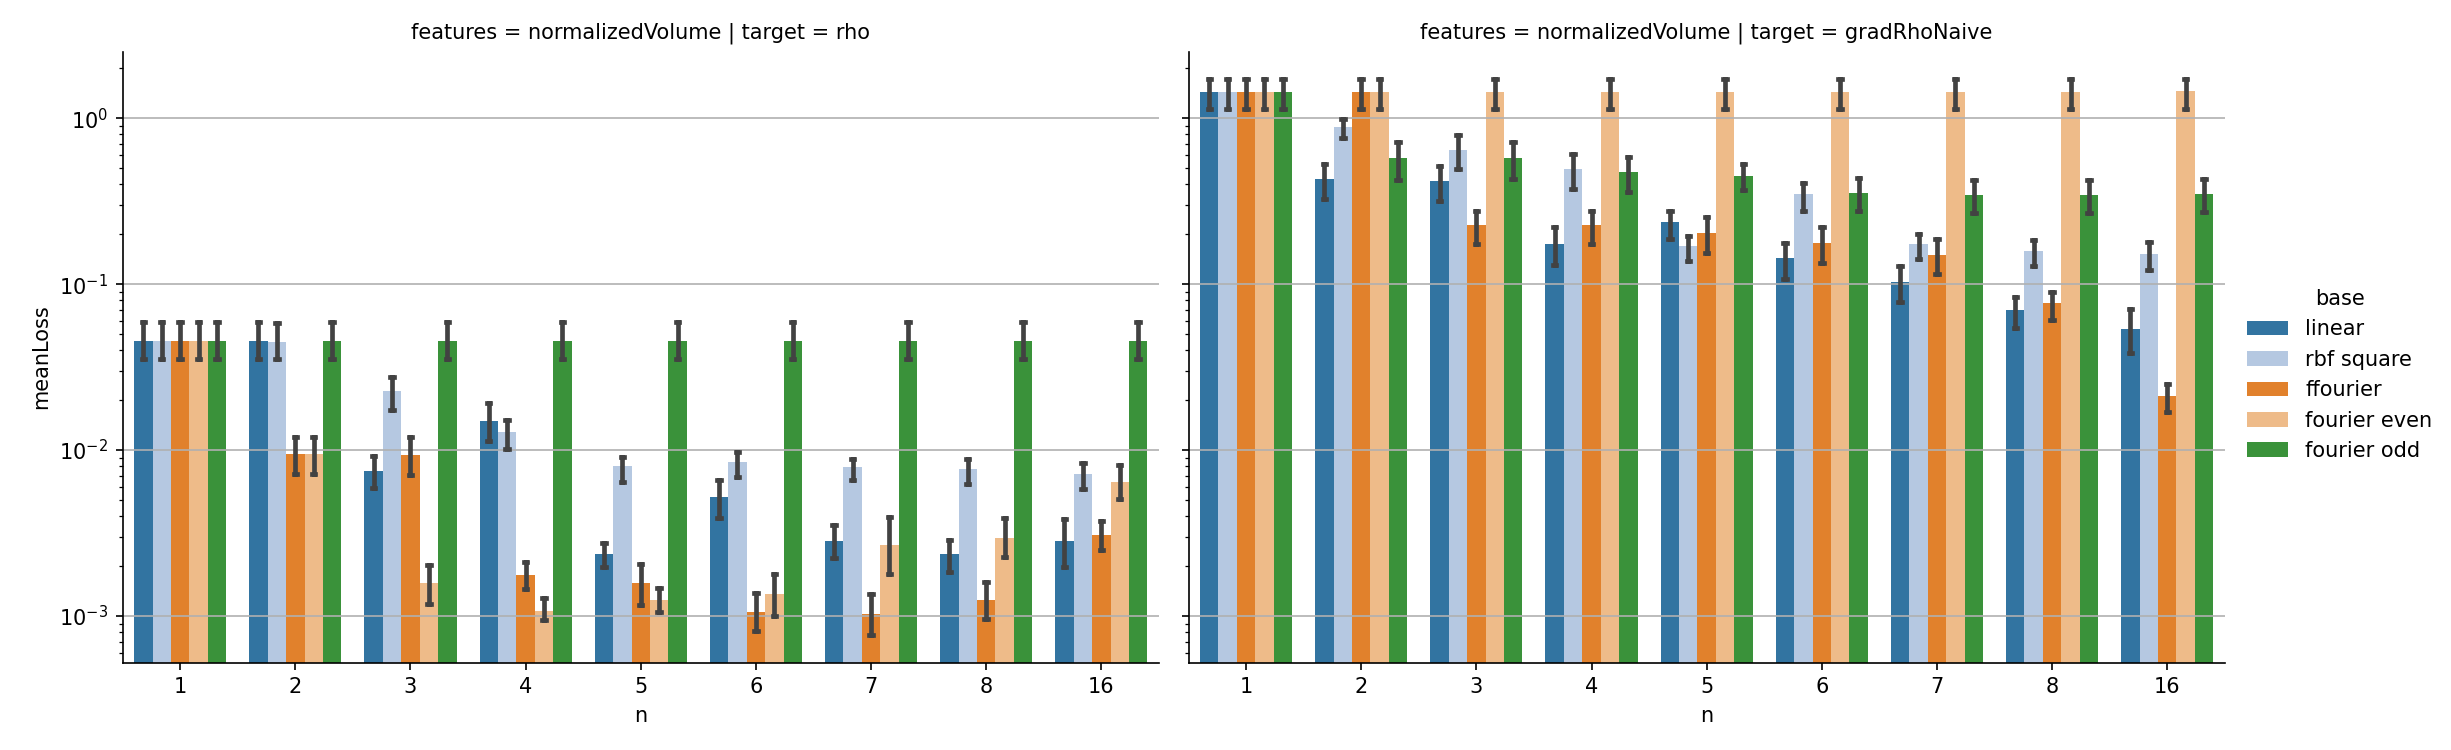

IndexError: index 2 is out of bounds for axis 1 with size 2

In [24]:
# g = sns.catplot(data = ablationStudy[ablationStudy['base']!='fourier'], x = 'n', y = 'meanLoss', hue = 'base', aspect = 2.0, capsize = .05, kind = 'bar')
g = sns.catplot(data = ablationStudy, x = 'n', y = 'meanLoss', hue = 'base', aspect = 1.5, capsize = .15, kind = 'bar', errorbar = ('pi'), row = 'features', col = 'target', palette = palette)


g.axes[0,0].set_yscale('log')
# g.axes[0,1].set_title('R2')
# g.axes[0,2].set_title('PSNR')
g.axes[0,0].grid(which = 'major', axis = 'y')
g.axes[0,1].grid(which = 'major', axis = 'y')
g.axes[0,2].grid(which = 'major', axis = 'y')
g.axes[0,0].set_axisbelow(True)
g.axes[0,1].set_axisbelow(True)
g.axes[0,2].set_axisbelow(True)
g.set_xticklabels(rotation=40, ha = 'right') 

g.axes[0,0].set_title(r'Target: $\rho$, Coordinate Mapping: Identity')
g.axes[0,0].set_title(r'Target: $\rho$, Coordinate Mapping: Polar')
g.axes[0,0].set_title(r'Target: $\rho$, Coordinate Mapping: Preserving')
g.axes[0,0].set_ylabel('Mean Testing Loss')
g.axes[0,0].set_xlabel('Input Feature')
g.axes[0,1].set_xlabel('Input Feature')
g.axes[0,2].set_xlabel('Input Feature')
# g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


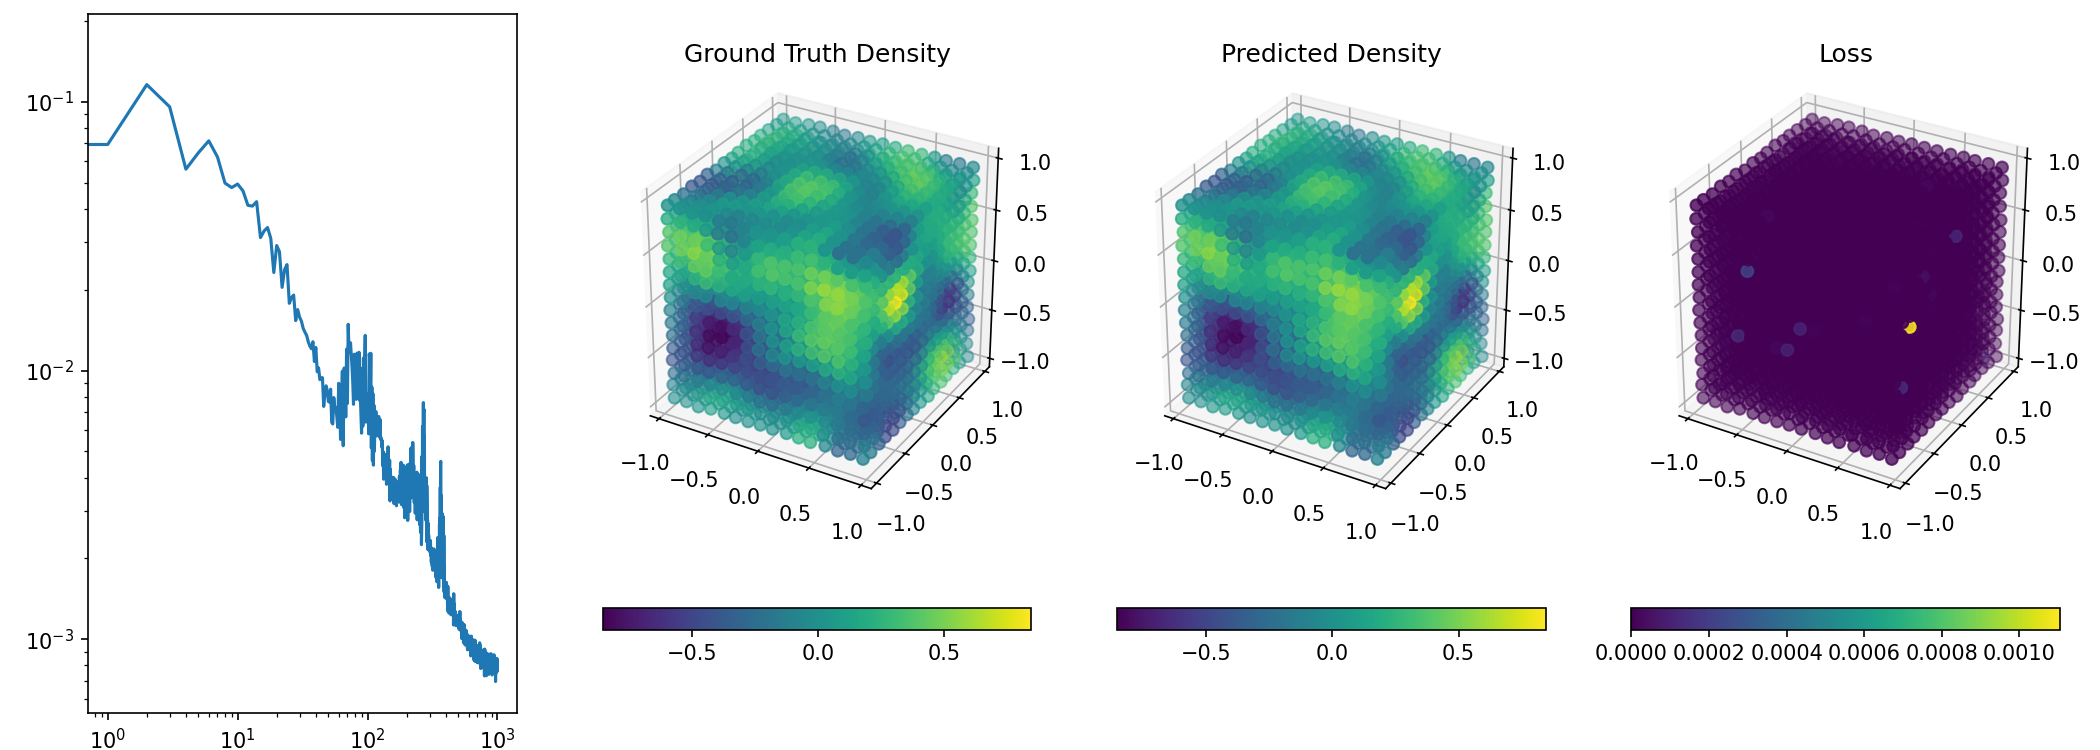

Mean Test Loss: 7.58878e-04


In [27]:
# args.features = 'normalizedVolume'
# args.target = 'rho'
# args.arch = '1'
# args.epochs = 1
# args.batch_size = 4
# args.initialLR = 1e-2
# args.lrStep = 10
# args.finalLR = 1e-4

args.iterations = 1000
args.nx = args.ny = args.nz = 8
# args.windowFunction = 'None'
args.rbf_x = args.rbf_y = args.rbf_z = 'ffourier'
# args.coordinateMapping = 'cartesian'

model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset = trainNetworkUsingArgs(args,inFile, dataOverride = None, testingData = testingData)
print('Mean Test Loss: %1.5e' % testDataset['meanLoss'].mean())

In [24]:
# args.features = 'normalizedVolume'
# args.target = 'rho'
# args.arch = '1'
# args.epochs = 1
# args.batch_size = 4
# args.initialLR = 1e-2
# args.lrStep = 10
# args.finalLR = 1e-4

args.iterations = 1000
args.nx = args.ny = args.nz = 8
# args.windowFunction = 'None'
args.rbf_x = args.rbf_y = args.rbf_z = 'linear'
# args.coordinateMapping = 'cartesian'

model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset = trainNetworkUsingArgs(args,inFile, dataOverride = None, testingData = testingData)
print('Mean Test Loss: %1.5e' % testDataset['meanLoss'].mean())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

batchedLoss: tensor([0.0003], device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)


<IPython.core.display.Javascript object>


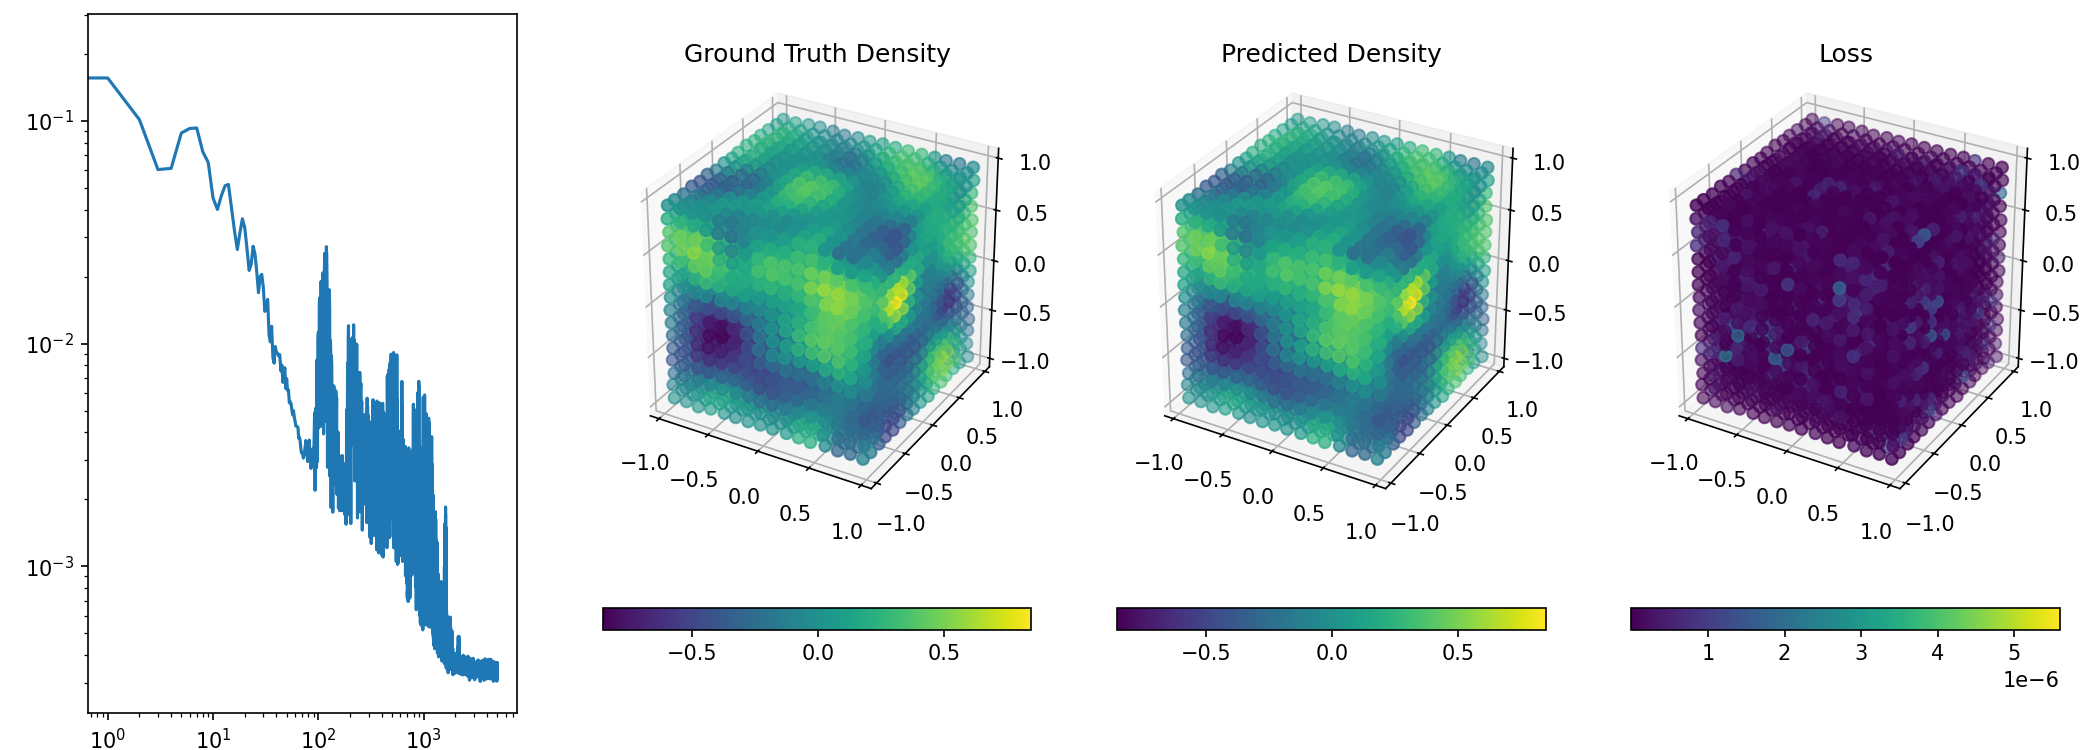

Mean Test Loss: 4.82925e-04


In [20]:
# args.features = 'normalizedVolume'
# args.target = 'rho'
# args.arch = '1'
# args.epochs = 1
# args.batch_size = 4
# args.initialLR = 1e-2
# args.lrStep = 10
# args.finalLR = 1e-4

args.iterations =5000
args.nx = args.ny = args.nz = 4
# args.windowFunction = 'None'
args.rbf_x = args.rbf_y = args.rbf_z = 'fourier even'
# args.coordinateMapping = 'cartesian'

model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset = trainNetworkUsingArgs(args,inFile, dataOverride = None, testingData = testingData)
print('Mean Test Loss: %1.5e' % testDataset['meanLoss'].mean())

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

batchedLoss: tensor([0.0108], device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)


<IPython.core.display.Javascript object>


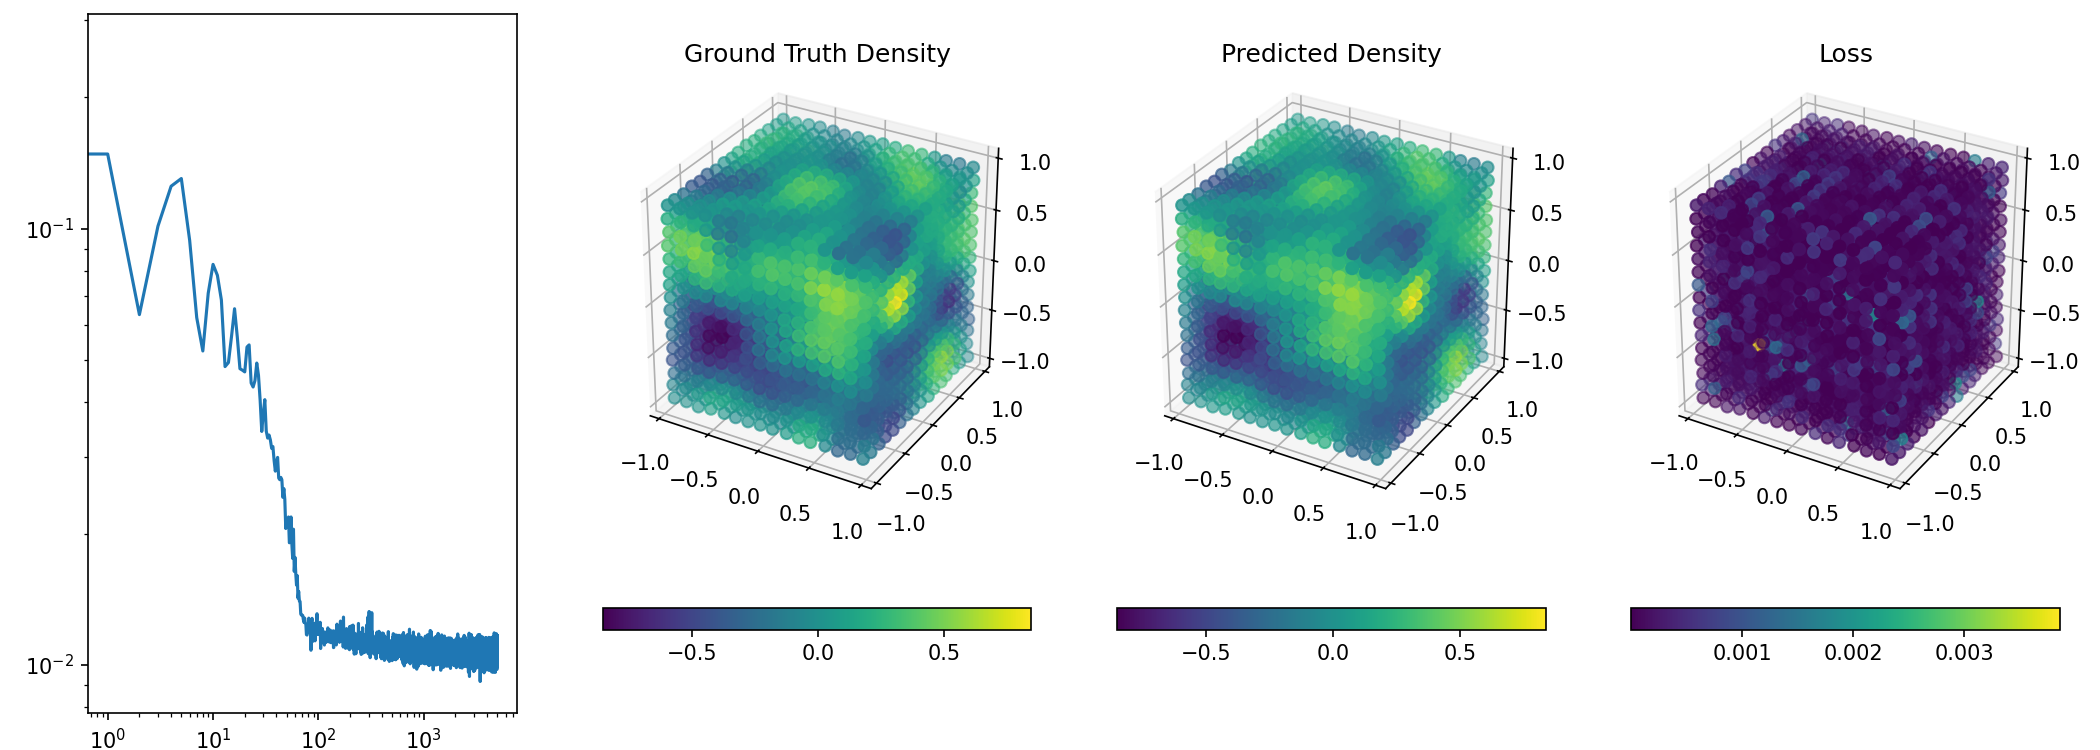

Mean Test Loss: 1.45898e-02


In [21]:
# args.features = 'normalizedVolume'
# args.target = 'rho'
# args.arch = '1'
# args.epochs = 1
# args.batch_size = 4
# args.initialLR = 1e-2
# args.lrStep = 10
# args.finalLR = 1e-4

# args.nx = args.ny = args.nz = 4
args.windowFunction = 'None'
args.rbf_x = args.rbf_y = args.rbf_z = 'linear'
# args.coordinateMapping = 'cartesian'

model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData, testDataset = trainNetworkUsingArgs(args,inFile, dataOverride = None, testingData = testingData)
print('Mean Test Loss: %1.5e' % testDataset['meanLoss'].mean())

In [73]:
import itertools

bases = testDataset['base'].unique()
networkSeeds = testDataset['networkSeed'].unique()
ns = testDataset['n'].unique()

configurations = [w + ' x ' + str(n) + ' @ Seed: ' + str(m) for w,n,m in list(itertools.product(bases, ns, networkSeeds))]

print(configurations)
palette = sns.color_palette('tab20', len(configurations))

['fourier even x 4 @ Seed: 42']


In [160]:
display(testDataset)

base  n arch        map window            seed  networkSeed  \
0   fourier even  4    1  cartesian   None         2912741           42   
1   fourier even  4    1  cartesian   None          519984           42   
2   fourier even  4    1  cartesian   None         1563928           42   
3   fourier even  4    1  cartesian   None        23874594           42   
4   fourier even  4    1  cartesian   None          463236           42   
5   fourier even  4    1  cartesian   None      2512459812           42   
6   fourier even  4    1  cartesian   None   3912845398145           42   
7   fourier even  4    1  cartesian   None       595381246           42   
8   fourier even  4    1  cartesian   None  39818259468124           42   
9   fourier even  4    1  cartesian   None     49325386124           42   
10  fourier even  4    1  cartesian   None        32898147           42   
11  fourier even  4    1  cartesian   None        89123968           42   
12  fourier even  4    1  cartesian   None      2741982453           42   
13  fourier even  4    1  cartesian   None       319562498           42   
14  fourier even  4    1  cartesian   None       918464356           42   
15  fourier even  4    1  cartesian   None       894263481           42   

    meanLoss                                               loss  \
0   0.001051  [0.0009401020014094381, 8.662931816952324e-05,...   
1   0.000950  [0.0002474414770692185, 0.00207977520758601, 0...   
2   0.001089  [0.000962655892719497, 0.0007801194935702603, ...   
3   0.001203  [3.537962385575383e-05, 0.0005741483400344832,...   
4   0.000953  [0.0008824111485430386, 0.002026130003243698, ...   
5   0.000856  [0.0011157721094918818, 0.0016939274406603255,...   
6   0.000925  [9.565098143509733e-05, 0.00012015886670723938...   
7   0.000952  [0.0009985073888824428, 0.0018465157965686374,...   
8   0.000928  [0.00017084473599610073, 0.002982813186986677,...   
9   0.001111  [0.00018904631428064145, 0.0007679979373868273...   
10  0.000963  [0.00168213907459544, 0.0012533125538136403, 0...   
11  0.001032  [0.00021361201875747752, 5.969560405258423e-05...   
12  0.001033  [1.7263289714075647e-05, 0.0006923150482739948...   
13  0.001029  [1.6241027952869358e-05, 0.0004329426639344547...   
14  0.000949  [0.0009905494045992225, 0.00082947034278813, 7...   
15  0.000946  [0.0005301262906468041, 0.013431245545652781, ...   

                                           prediction  \
0   [-0.0013458376976173709, -0.16547664427345382,...   
1   [-0.0720970721794297, -0.21907731185297674, -0...   
2   [-0.008853984291963567, 0.02387692537436229, -...   
3   [0.011981643733493079, 0.08493726061085002, 0....   
4   [0.03699462198568139, 0.18133192907435267, 0.1...   
5   [-0.03942186434889935, -0.2758031077187427, -0...   
6   [-0.008833592915141839, -0.014746217165318945,...   
7   [0.031464763818041676, 0.0385727925777391, 0.0...   
8   [-0.04236460199187084, -0.353399354936391, -0....   
9   [-0.09515986336605, -0.05940920013398365, -0.2...   
10  [0.050369905093179436, 0.15469226015802118, 0....   
11  [-0.005104694606332932, -0.09633600409836277, ...   
12  [0.07182946073031202, 0.2230379461924109, 0.22...   
13  [0.023855652164758757, -0.25041225652013754, -...   
14  [0.06961249535884616, 0.3650105514894909, 0.49...   
15  [0.03839925333973726, 0.1134168682189019, 0.16...   

                                                   gt  
0   [-0.0004057356962079328, -0.16556327359162334,...  
1   [-0.07234451365649892, -0.22115708706056275, -...  
2   [-0.00789132839924407, 0.02309680588079203, -0...  
3   [0.012017023357348833, 0.08551140895088451, 0....  
4   [0.03787703313422443, 0.18335805907759636, 0.1...  
5   [-0.038306092239407466, -0.2741091802780824, -...  
6   [-0.008737941933706741, -0.014866376032026184,...  
7   [0.03246327120692412, 0.036726276781170464, 0....  
8   [-0.04253544672786694, -0.3563821681233777, -0...  
9   [-0.09534890968033063, -0.058641202196596826, ...  
10  [0.048

In [151]:
# fig, axis = plt.subplots(2, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

for i, (w, n, m) in enumerate(list(itertools.product(bases, ns, networkSeeds))):
    config = w + ' x ' + str(n) + ' @ Seed: ' + str(m)
    
    curLoss = np.hstack(testDataset['loss'][np.logical_and(testDataset['base'] == w, np.logical_and(testDataset['n'] == n, testDataset['networkSeed'] == m))].tolist())
    curPred = np.hstack(testDataset['prediction'][np.logical_and(testDataset['base'] == w, np.logical_and(testDataset['n'] == n, testDataset['networkSeed'] == m))].tolist())
    curGT = np.hstack(testDataset['gt'][np.logical_and(testDataset['base'] == w, np.logical_and(testDataset['n'] == n, testDataset['networkSeed'] == m))].tolist())
    
    df = pandas.DataFrame({'loss': curLoss,'pred': curPred,'gt': curGT})
    df['config'] = config
    df['Basis'] = w
    df['n'] = n
    df['networkSeed'] = m
#     display(df)
    
    df['relative_x'] = np.abs(df['pred'] - df['gt'])
    df['relative_y'] = np.abs(df['pred']) + np.abs(df['gt'])
    df['relative'] = df['relative_x'] / df['relative_y']
    df = df.T
    display(df)
    sns.displot(data = df, row = ['loss'])
    

0                            1      \
loss                             0.00094                     0.000087   
pred                           -0.001346                    -0.165477   
gt                             -0.000406                    -0.165563   
config       fourier even x 4 @ Seed: 42  fourier even x 4 @ Seed: 42   
Basis                       fourier even                 fourier even   
n                                      4                            4   
networkSeed                           42                           42   
relative_x                       0.00094                     0.000087   
relative_y                      0.001752                      0.33104   
relative                        0.536719                     0.000262   

                                   2                            3      \
loss                            0.001327                     0.000281   
pred                           -0.333833                    -0.451899   
gt                              -0.33516                     -0.45218   
config       fourier even x 4 @ Seed: 42  fourier even x 4 @ Seed: 42   
Basis                       fourier even                 fourier even   
n                                      4                            4   
networkSeed                           42                           42   
relative_x                      0.001327                     0.000281   
relative_y                      0.668993                     0.904079   
relative                        0.001983                     0.000311   

                                   4                            5      \
loss                            0.000803                     0.000869   
pred                           -0.530554                    -0.466999   
gt                             -0.531357                    -0.467868   
config       fourier even x 4 @ Seed: 42  fourier even x 4 @ Seed: 42   
Basis                       fourier even                 fourier even   
n                                      4                            4   
networkSeed                           42                           42   
relative_x                      0.000803                     0.000869   
relative_y                      1.061912                     0.934867   
relative                        0.000756                     0.000929   

                                   6                            7      \
loss                            0.000593                     0.000163   
pred                           -0.273522                    -0.098758   
gt                              -0.27293                    -0.098922   
config       fourier even x 4 @ Seed: 42  fourier even x 4 @ Seed: 42   
Basis                       fourier even                 fourier even   
n                                      4                            4   
networkSeed                           42                           42   
relative_x                      0.000593                     0.000163   
relative_y                      0.546452                      0.19768   
relative                        0.001085                     0.000827   

                                   8                            9      ...  \
loss                            0.000281                     0.000927  ...   
pred                            0.036363                      0.15894  ...   
gt                              0.036644                     0.159867  ...   
config       fourier even x 4 @ Seed: 42  fourier even x 4 @ Seed: 42  ...   
Basis                       fourier even                 fourier even  ...   
n                                      4                            4  ...   
networkSeed                           42                           42  ...   
relative_x                      0.000281                     0.000927  ...   
relative_y                      0.073007                     0.318807  ...   
relative                        0.00384

ValueError: The following variable cannot be assigned with wide-form data: `row`

<IPython.core.display.Javascript object>


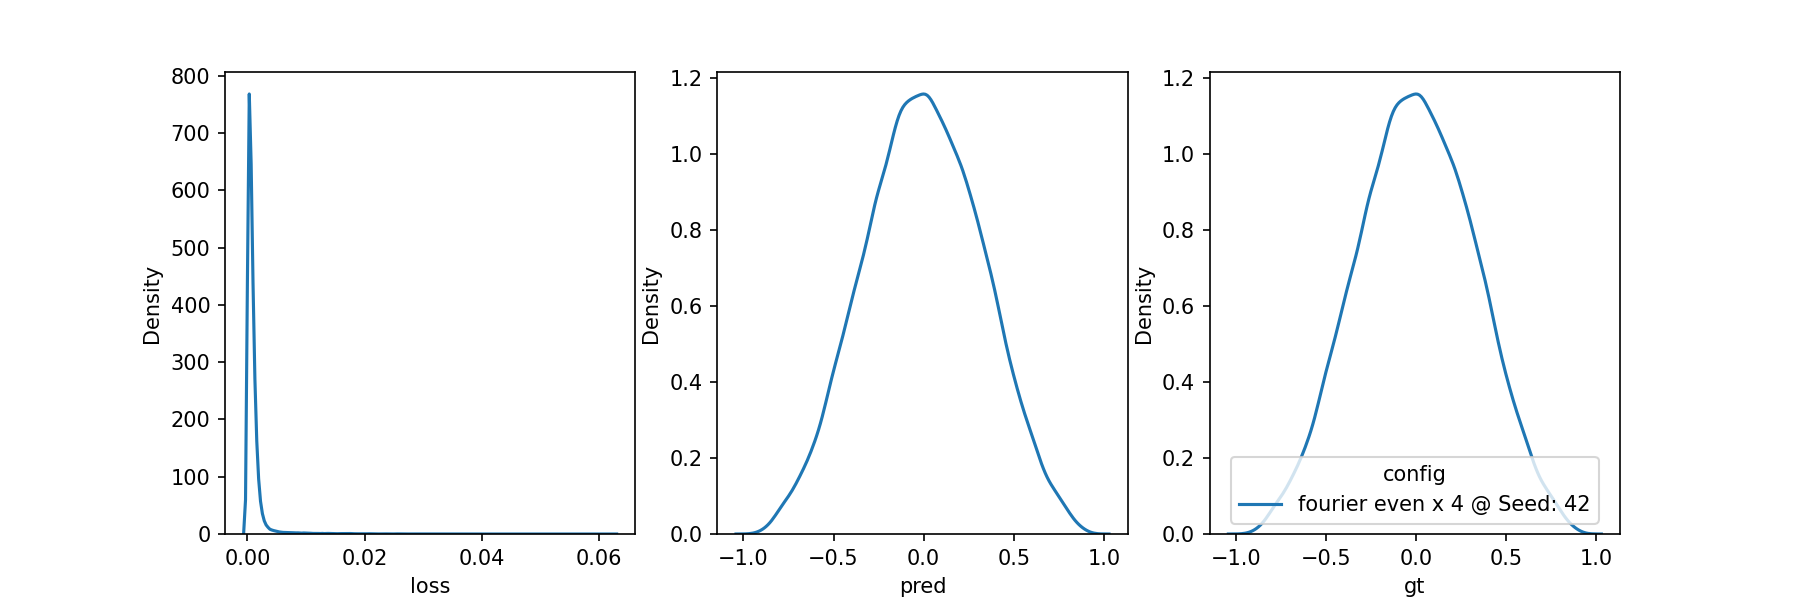

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


In [159]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

for i, (w, n, m) in enumerate(list(itertools.product(bases, ns, networkSeeds))):
    config = w + ' x ' + str(n) + ' @ Seed: ' + str(m)
    
    curLoss = np.hstack(testDataset['loss'][np.logical_and(testDataset['base'] == w, np.logical_and(testDataset['n'] == n, testDataset['networkSeed'] == m))].tolist())
    curPred = np.hstack(testDataset['prediction'][np.logical_and(testDataset['base'] == w, np.logical_and(testDataset['n'] == n, testDataset['networkSeed'] == m))].tolist())
    curGT = np.hstack(testDataset['gt'][np.logical_and(testDataset['base'] == w, np.logical_and(testDataset['n'] == n, testDataset['networkSeed'] == m))].tolist())
    
    df = pandas.DataFrame({'loss': curLoss,'pred': curPred,'gt': curGT})
    df['config'] = config
    df['Basis'] = w
    df['n'] = n
    df['networkSeed'] = m
#     display(df)
    
    df['relative_x'] = np.abs(df['pred'] - df['gt'])
    df['relative_y'] = np.abs(df['pred']) + np.abs(df['gt'])
    df['relative'] = df['relative_x'] / df['relative_y']
#     df = df.T
    
#     sns.displot(df, row = ['loss'])
    
    sns.kdeplot(data = df, ax = axis[0,0], x = 'loss', hue = 'config', palette = palette, hue_order = configurations )
    sns.kdeplot(data = df, ax = axis[0,1], x = 'pred', hue = 'config', palette = palette, hue_order = configurations )
    
# #     sns.scatter(data = df, ax = axis[1,0], x = 'relative_y', y = 'relative_x', hue = 'config', palette = palette, hue_order = configurations)
#     sns.kdeplot(data = df, ax = axis[1,0], x = 'relative', hue = 'config', palette = palette, hue_order = configurations)
    g = sns.kdeplot(data = df, ax = axis[0,2], x = 'gt', hue = 'config', palette = palette, hue_order = configurations )
#     handles, labels = axis[1,1].get_legend_handles_labels()
    
# axes = axis.flatten()
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc = 'lower center')
# #     print(handles, labels)
axis[0,0].get_legend().remove()
axis[0,1].get_legend().remove()
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
sns.move_legend(g, bbox_to_anchor=(0.5, 0), loc = 'lower center')
# g.legend(bbox_to_anchor=(0.5, 0), loc = 'lower center')
# axis[1,0].get_legend().remove()
# axis[1,1].get_legend().remove()
# fig.subplots_adjust(bottom=0.2)
# fig.subplots_adjust(bottom=0.15, right = 0.99, left = 0.075, top = 0.95)

# axis[0,0].set_xlabel('Loss KDE')
# axis[0,1].set_xlabel('Prediction KDE')
# axis[1,1].set_xlabel('Ground Truth KDE')
# axis[1,0].set_xlabel('|Prediction - GT| / (|Prediction| + |GT|)')
# axis[1,0].set_ylabel('|Prediction - GT|')
#     fig.legend(handles, labels, loc = 'lower center')
# display(testDataset.ravel())
# fig.tight_layout()



In [128]:
axis[1,0].set_xscale('symlog')
axis[1,0].set_yscale('linear')

In [141]:
axis[0,0].get_legend_handles_labels()

([], [])

array([9.40102001e-04, 8.66293182e-05, 1.32692137e-03, ...,
       1.10982817e-03, 1.76684096e-04, 5.38288085e-03])

In [53]:
sns.kdeplot(testDataset, x = 'loss', hue = 'seed')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

batchedLoss: tensor([0.0009], device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)


<IPython.core.display.Javascript object>


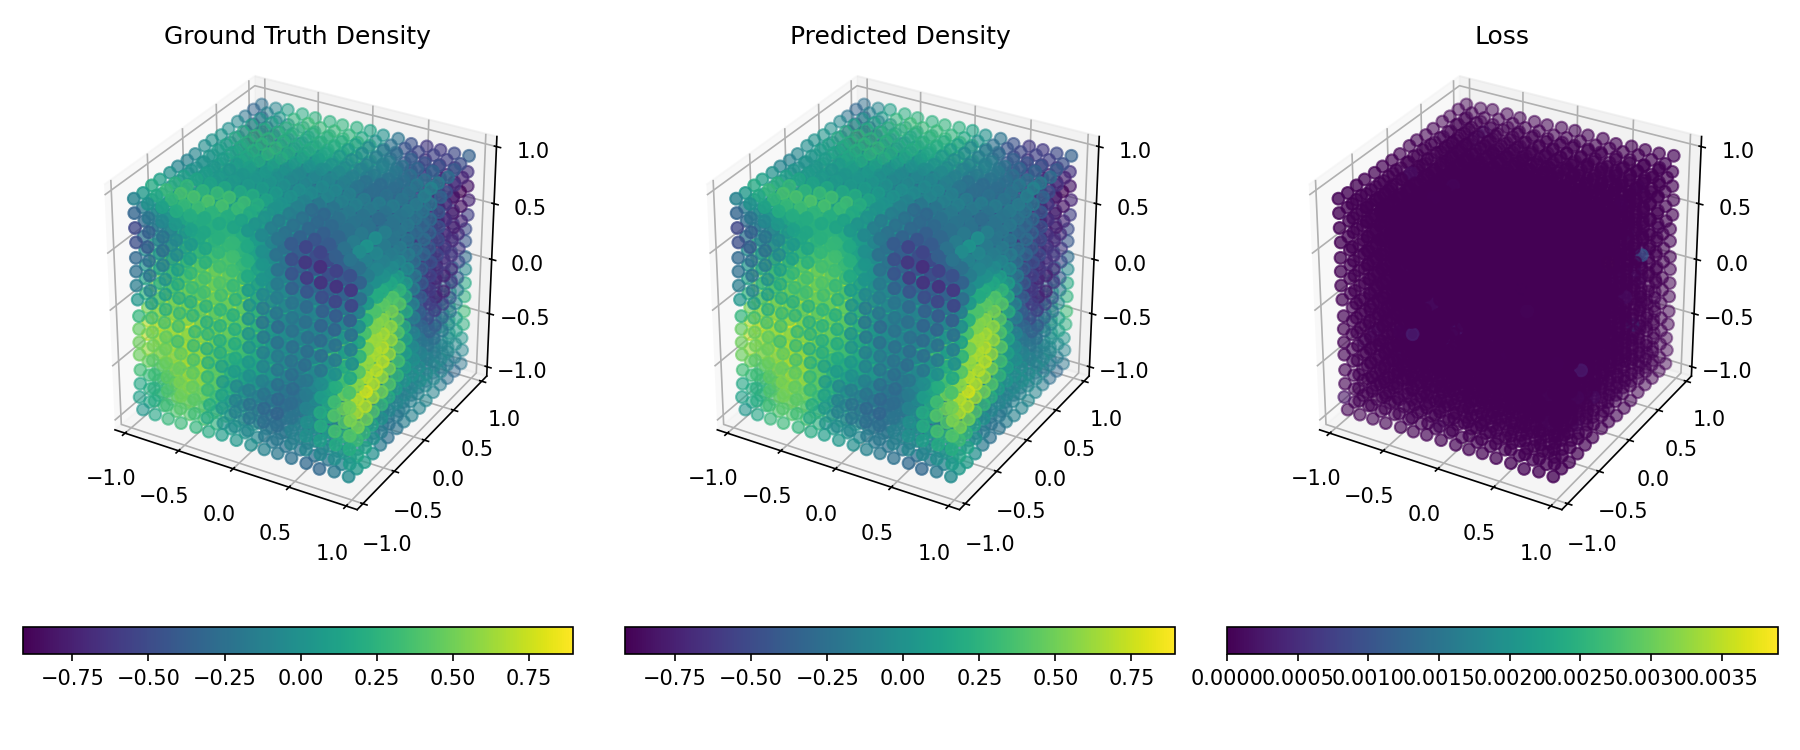

In [17]:
plotTestLoss(model, inFile, hyperParameterDict, testingData[0])

In [16]:
def plotTestLoss(model, inFile, hyperParameterDict, generatedData):
    bdata = [list(inFile['simulationData'].keys())[0]]
    loss, features, prediction, gt = processBatch(bdata, model, inFile, features = hyperParameterDict['features'], target = hyperParameterDict['target'], li = hyperParameterDict['liLoss'] == 'yes', dataOverride = [generatedData])
    batchedLoss = torch.mean(loss, dim = -1)
    loss = torch.mean(loss)
    print('batchedLoss:', batchedLoss)

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = gt[:,0].detach().cpu(), s = 32)
    # fig.colorbar(sc, ax=ax)
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_box_aspect([1,1,1]) 
    ax.set_title('Ground Truth Density')

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = prediction.detach().cpu(), s = 32)
    # fig.colorbar(sc, ax=ax)
    ax.set_box_aspect([1,1,1]) 
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_title('Predicted Density')

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = ((prediction - gt)**2).detach().cpu(), s = 32)
    fig.colorbar(sc, ax=ax,orientation = 'horizontal')
    ax.set_box_aspect([1,1,1]) 
    ax.set_title('Loss')

    fig.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

batchedLoss: tensor([0.0227], device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)


<IPython.core.display.Javascript object>


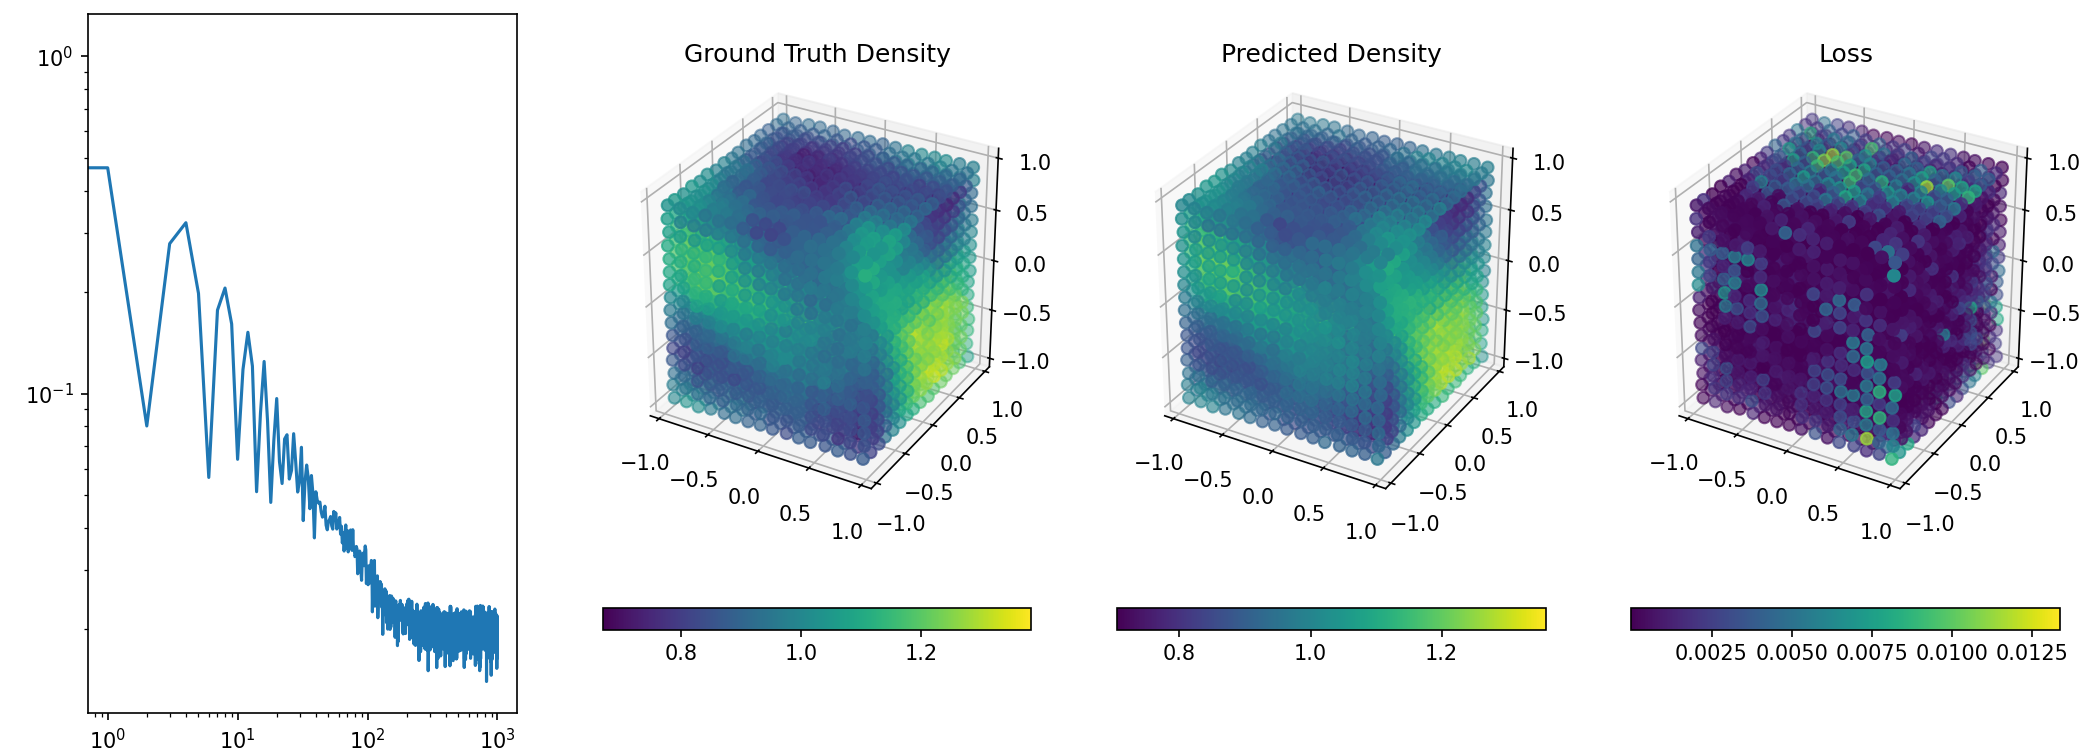

(RbfNet(
   (convs): ModuleList(
     (0): RbfConv(1, 1, dim=3)
   )
   (fcs): ModuleList()
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.01
     lr: 9.999999999999933e-05
     maximize: False
     weight_decay: 0
 ),
 {'nx': 4,
  'ny': 4,
  'nz': 4,
  'coordinateMapping': 'cartesian',
  'rbf_x': 'linear',
  'rbf_y': 'linear',
  'rbf_z': 'linear',
  'windowFunction': 'None',
  'liLoss': False,
  'initialLR': 0.01,
  'finalLR': 0.0001,
  'lrStep': 10,
  'lrSteps': 99,
  'gamma': 0.954548456661834,
  'epochs': 1,
  'iterations': 1000,
  'totalIterations': 1000,
  'arch': '1',
  'seed': 42,
  'augmentAngle': True,
  'augmentJitter': True,
  'jitterAmount': 0.01,
  'networkSeed': 42,
  'network': 'default',
  'normalized': False,
  'adjustForFrameDistance': True,
  'fluidFeatures': 1,
  'boundaryFeatures': 0,
  'cutlassBatchSize': 128,
  'we

In [18]:
args.features = 'normalizedVolume'
args.target = 'rho'
args.arch = '1'
args.epochs = 1
args.batch_size = 4
args.initialLR = 1e-2
args.lrStep = 10
args.finalLR = 1e-4

args.nx = args.ny = args.nz = 4
args.windowFunction = 'None'
args.rbf_x = args.rbf_y = args.rbf_z = 'linear'
args.coordinateMapping = 'cartesian'

model, optimizer, scheduler, hyperParameterDict, parameterDict, trainingEpochLosses, generatedData = trainNetworkUsingArgs(args,inFile, dataOverride = None)

In [ ]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
#     for i in range(4):
#         with record_function("Forward Pass"): 
#             loss,_,_,_ = processBatch(bdata, model, inFile, features = hyperParameterDict['features'], target = hyperParameterDict['target'], li = hyperParameterDict['liLoss'] == 'yes')
#             batchLosses = torch.mean(loss, dim = -1)
#             loss = torch.mean(loss)

#         with record_function("Backward Pass"): 
#             loss.backward()
#             optimizer.step()
        
# # print(prof.key_averages().table(sort_by='self_cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))

# prof.export_chrome_trace("traceGPU.json")